In [204]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import mahalanobis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from statsmodels.stats.multitest import multipletests
import warnings
import json
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
from datetime import datetime
TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

print("Libraries loaded successfully!")
print(f"Analysis timestamp: {TIMESTAMP}")


Libraries loaded successfully!
Analysis timestamp: 20260110_201855


## 1. Configuration

In [205]:
# =============================================================================
# CONFIGURATION - Modify these paths as needed
# =============================================================================

# Data paths
SYNTHETIC_DATA_PATH = '/home/smotaali/BGP_Traffic_Generation/results/SMOTE_enhanced/synthetic_likely_normal_enhanced_kmeans.csv'
REAL_DATA_PATH = '/home/smotaali/BGP_Traffic_Generation/results/final_label_results_HDBSCAN/rrc04_updates_20251116_extracted_discovered.csv'

# Output directory for results
OUTPUT_DIR = '/home/smotaali/BGP_Traffic_Generation/results/SMOTE_enhanced/kmeans_v3_rrc04/'
# Random seed for reproducibility
RANDOM_SEED = 42

# Significance level for statistical tests
ALPHA = 0.05

# Columns to exclude from analysis
EXCLUDE_COLS = ['sequence_id', 'timestep', 'label', 'window_start', 'window_end', 
                'discovered_label', 'generation_method', 'log_transform_used', 'bgp_constraints_enforced']

# KS statistic thresholds (for large sample interpretation)
KS_EXCELLENT_THRESHOLD = 0.05  # Very similar distributions
KS_GOOD_THRESHOLD = 0.10       # Reasonably similar
KS_MODERATE_THRESHOLD = 0.15   # Moderate similarity

# Cohen's d cap for numeric stability
COHENS_D_CAP = 10.0  # Cap extreme values

# =============================================================================
# ENHANCED: Per-Feature Importance Weights for BGP Semantics
# =============================================================================
# Operationally critical BGP features get higher weights in similarity scoring
# These weights reflect the importance of each feature for BGP traffic validation

FEATURE_IMPORTANCE_WEIGHTS = {
    # --- PRIMARY BGP METRICS (Critical for traffic characterization) ---
    'announcements': 1.5,           # Core BGP activity
    'withdrawals': 1.5,             # Core BGP activity  
    'flaps': 1.5,                   # Network instability indicator
    'nadas': 1.3,                   # No-Advertise-to-Any (policy-related)
    'rare_ases': 1.3,               # Unusual AS appearances
    
    # --- SECONDARY BGP METRICS (Important but less critical) ---
    'unique_prefixes': 1.2,         # Prefix diversity
    'unique_ases': 1.2,             # AS diversity
    'avg_path_length': 1.2,         # Routing characteristics
    'max_path_length': 1.1,
    'avg_edit_distance': 1.1,
    
    # --- EDIT DISTANCE BUCKETS (Statistical, less operationally critical) ---
    'edit_dist_0': 0.8,             # No change
    'edit_dist_1': 0.9,
    'edit_dist_2': 0.9,
    'edit_dist_3': 0.9,
    'edit_dist_4_plus': 0.8,
    
    # --- DEFAULT for unlisted features ---
    '_default': 1.0
}

# Top-K worst features to display
TOP_K_WORST_FEATURES = 10

print("Configuration set!")
print(f"\nFeature importance weights defined for {len(FEATURE_IMPORTANCE_WEIGHTS)-1} features")
print(f"Top-K worst features to report: {TOP_K_WORST_FEATURES}")


Configuration set!

Feature importance weights defined for 15 features
Top-K worst features to report: 10


## 2. Load and Prepare Data

In [206]:
# Load datasets
synthetic_full = pd.read_csv(SYNTHETIC_DATA_PATH)
real_full = pd.read_csv(REAL_DATA_PATH)

print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"\nSynthetic Data Shape: {synthetic_full.shape}")
print(f"Real Data Shape: {real_full.shape}")
print(f"\nSynthetic Labels:\n{synthetic_full['label'].value_counts()}")
print(f"\nReal Labels:\n{real_full['discovered_label'].value_counts()}")


DATASET OVERVIEW

Synthetic Data Shape: (19994, 32)
Real Data Shape: (86387, 38)

Synthetic Labels:
label
synthetic    19994
Name: count, dtype: int64

Real Labels:
discovered_label
likely_normal              67940
uncertain                  11248
high_confidence_anomaly     5168
likely_anomaly              2031
Name: count, dtype: int64


In [207]:
# Filter only normal traffic from both datasets
synthetic_normal = synthetic_full[synthetic_full['label'] == 'synthetic'].copy()
real_normal = real_full[real_full['discovered_label'] == 'likely_normal'].copy()

print(f"Synthetic Normal samples: {len(synthetic_normal)}")
print(f"Real Normal samples: {len(real_normal)}")


Synthetic Normal samples: 19994
Real Normal samples: 67940


In [208]:
# Sample equal amounts for fair comparison
n_samples = min(len(synthetic_normal), len(real_normal))
print(f"\nUsing {n_samples} samples from each dataset for comparison")

# Use all synthetic normal (smaller dataset)
synthetic_sampled = synthetic_normal.copy()

# Random sample from real data
np.random.seed(RANDOM_SEED)
real_sampled = real_normal.sample(n=n_samples, random_state=RANDOM_SEED).copy()

print(f"Synthetic sampled: {len(synthetic_sampled)}")
print(f"Real sampled: {len(real_sampled)}")



Using 19994 samples from each dataset for comparison
Synthetic sampled: 19994
Real sampled: 19994


In [209]:
# Get feature columns (exclude metadata columns)
EXCLUDE_COLS = ['timestamp','sequence_id','label','discovered_label', 'generation_method', 'log_transform_used', 'bgp_constraints_enforced']
feature_cols = [col for col in synthetic_sampled.columns if col not in EXCLUDE_COLS]

print(f"\nNumber of features to compare: {len(feature_cols)}")
print(f"\nFeatures: {feature_cols}")




Number of features to compare: 27

Features: ['announcements', 'withdrawals', 'nlri_ann', 'dups', 'origin_0', 'origin_2', 'origin_changes', 'imp_wd', 'imp_wd_spath', 'imp_wd_dpath', 'as_path_max', 'unique_as_path_max', 'edit_distance_max', 'edit_distance_dict_0', 'edit_distance_dict_1', 'edit_distance_dict_2', 'edit_distance_dict_3', 'edit_distance_dict_4', 'edit_distance_dict_5', 'edit_distance_dict_6', 'edit_distance_unique_dict_0', 'edit_distance_unique_dict_1', 'number_rare_ases', 'nadas', 'flaps', 'edit_distance_avg', 'rare_ases_avg']


In [210]:
# IMPROVED: Comprehensive constant feature handling
# - Constant in both: exclude from analysis (no information)
# - Constant in synthetic only: FLAG as GAN issue (not learning variance)
# - Constant in real only: FLAG as data artifact (rare)
constant_both = []
constant_synthetic_only = []  # Potential GAN issue
constant_real_only = []       # Potential data issue
valid_features = []

for col in feature_cols:
    syn_std = synthetic_sampled[col].std()
    real_std = real_sampled[col].std()
    
    if syn_std == 0 and real_std == 0:
        constant_both.append(col)
    elif syn_std == 0 and real_std > 0:
        constant_synthetic_only.append({
            'feature': col, 
            'real_std': real_std, 
            'real_mean': real_sampled[col].mean(),
            'syn_value': synthetic_sampled[col].iloc[0]
        })
    elif syn_std > 0 and real_std == 0:
        constant_real_only.append({
            'feature': col, 
            'syn_std': syn_std, 
            'syn_mean': synthetic_sampled[col].mean(),
            'real_value': real_sampled[col].iloc[0]
        })
    else:
        valid_features.append(col)

print(f"Total feature columns: {len(feature_cols)}")
print(f"\n" + "=" * 60)
print("CONSTANT FEATURE ANALYSIS")
print("=" * 60)

print(f"\nConstant in BOTH datasets (excluded - no information): {len(constant_both)}")
if constant_both:
    print(f"   Features: {constant_both}")

print(f"\n[WARNING] Constant in SYNTHETIC only (GAN issue - not learning variance): {len(constant_synthetic_only)}")
if constant_synthetic_only:
    for item in constant_synthetic_only:
        print(f"   - {item['feature']}:")
        print(f"     Synthetic: constant at {item['syn_value']:.4f}")
        print(f"     Real: mean={item['real_mean']:.4f}, std={item['real_std']:.4f}")
    print(f"   ACTION NEEDED: GAN is not learning variance for these features!")

print(f"\n[WARNING] Constant in REAL only (unusual - check data): {len(constant_real_only)}")
if constant_real_only:
    for item in constant_real_only:
        print(f"   - {item['feature']}:")
        print(f"     Real: constant at {item['real_value']:.4f}")
        print(f"     Synthetic: mean={item['syn_mean']:.4f}, std={item['syn_std']:.4f}")

# Store problematic features for final report
problematic_features = {
    'constant_both': constant_both,
    'constant_synthetic_only': constant_synthetic_only,
    'constant_real_only': constant_real_only
}

# Use only fully valid features for main analysis
feature_cols = valid_features
print(f"\nValid features for statistical comparison: {len(feature_cols)}")
print(f"   Features: {feature_cols}")


Total feature columns: 27

CONSTANT FEATURE ANALYSIS

Constant in BOTH datasets (excluded - no information): 0

[WARNING] Constant in SYNTHETIC only (GAN issue - not learning variance): 0

[WARNING] Constant in REAL only (unusual - check data): 0

Valid features for statistical comparison: 27
   Features: ['announcements', 'withdrawals', 'nlri_ann', 'dups', 'origin_0', 'origin_2', 'origin_changes', 'imp_wd', 'imp_wd_spath', 'imp_wd_dpath', 'as_path_max', 'unique_as_path_max', 'edit_distance_max', 'edit_distance_dict_0', 'edit_distance_dict_1', 'edit_distance_dict_2', 'edit_distance_dict_3', 'edit_distance_dict_4', 'edit_distance_dict_5', 'edit_distance_dict_6', 'edit_distance_unique_dict_0', 'edit_distance_unique_dict_1', 'number_rare_ases', 'nadas', 'flaps', 'edit_distance_avg', 'rare_ases_avg']


In [211]:
# Extract feature matrices
X_synthetic = synthetic_sampled[feature_cols].values
X_real = real_sampled[feature_cols].values

# Create DataFrames for analysis
df_synthetic = synthetic_sampled[feature_cols].copy()
df_real = real_sampled[feature_cols].copy()

print(f"Synthetic feature matrix shape: {X_synthetic.shape}")
print(f"Real feature matrix shape: {X_real.shape}")


Synthetic feature matrix shape: (19994, 27)
Real feature matrix shape: (19994, 27)


## 3. Calibration Check (Preprocessing Bias Detection)

In [212]:
# =============================================================================
# ENHANCED: Calibration Check - Detect Preprocessing Bias
# =============================================================================
# Compare means and standard deviations before and after scaling/normalization
# to ensure there is no preprocessing bias between real and synthetic datasets

print("=" * 80)
print("CALIBRATION CHECK: Preprocessing Bias Detection")
print("=" * 80)

# Store raw statistics BEFORE any scaling
calibration_results = []

for col in feature_cols:
    syn_mean_raw = df_synthetic[col].mean()
    syn_std_raw = df_synthetic[col].std()
    real_mean_raw = df_real[col].mean()
    real_std_raw = df_real[col].std()
    
    calibration_results.append({
        'feature': col,
        'syn_mean_raw': syn_mean_raw,
        'syn_std_raw': syn_std_raw,
        'real_mean_raw': real_mean_raw,
        'real_std_raw': real_std_raw,
        'mean_diff_raw': abs(syn_mean_raw - real_mean_raw),
        'std_ratio_raw': syn_std_raw / real_std_raw if real_std_raw > 0 else np.nan
    })

calibration_df_raw = pd.DataFrame(calibration_results)

# Combine and scale data (same as later analysis)
X_combined_for_calibration = np.vstack([X_synthetic, X_real])
scaler_calibration = StandardScaler()
X_scaled_calibration = scaler_calibration.fit_transform(X_combined_for_calibration)

# Split back
X_syn_scaled = X_scaled_calibration[:len(X_synthetic)]
X_real_scaled = X_scaled_calibration[len(X_synthetic):]

# Calculate post-scaling statistics
for i, col in enumerate(feature_cols):
    calibration_df_raw.loc[calibration_df_raw['feature'] == col, 'syn_mean_scaled'] = X_syn_scaled[:, i].mean()
    calibration_df_raw.loc[calibration_df_raw['feature'] == col, 'syn_std_scaled'] = X_syn_scaled[:, i].std()
    calibration_df_raw.loc[calibration_df_raw['feature'] == col, 'real_mean_scaled'] = X_real_scaled[:, i].mean()
    calibration_df_raw.loc[calibration_df_raw['feature'] == col, 'real_std_scaled'] = X_real_scaled[:, i].std()

# Calculate scaled differences
calibration_df_raw['mean_diff_scaled'] = abs(calibration_df_raw['syn_mean_scaled'] - calibration_df_raw['real_mean_scaled'])
calibration_df_raw['std_ratio_scaled'] = calibration_df_raw['syn_std_scaled'] / calibration_df_raw['real_std_scaled']

# Detect potential bias
BIAS_THRESHOLD_MEAN = 0.5  # Scaled mean difference threshold
BIAS_THRESHOLD_STD = 0.3   # Deviation from 1.0 for std ratio

calibration_df_raw['potential_mean_bias'] = calibration_df_raw['mean_diff_scaled'] > BIAS_THRESHOLD_MEAN
calibration_df_raw['potential_std_bias'] = abs(calibration_df_raw['std_ratio_scaled'] - 1.0) > BIAS_THRESHOLD_STD

print("\n--- RAW DATA STATISTICS (Before Scaling) ---")
print(f"Mean of mean differences: {calibration_df_raw['mean_diff_raw'].mean():.4f}")
print(f"Mean of std ratios (syn/real): {calibration_df_raw['std_ratio_raw'].mean():.4f}")

print("\n--- SCALED DATA STATISTICS (After StandardScaler) ---")
print(f"Mean of mean differences: {calibration_df_raw['mean_diff_scaled'].mean():.4f}")
print(f"Mean of std ratios (syn/real): {calibration_df_raw['std_ratio_scaled'].mean():.4f}")

# Check for bias
n_mean_bias = calibration_df_raw['potential_mean_bias'].sum()
n_std_bias = calibration_df_raw['potential_std_bias'].sum()

print(f"\n--- BIAS DETECTION ---")
print(f"Features with potential mean bias (scaled diff > {BIAS_THRESHOLD_MEAN}): {n_mean_bias}/{len(feature_cols)}")
print(f"Features with potential std bias (ratio deviation > {BIAS_THRESHOLD_STD}): {n_std_bias}/{len(feature_cols)}")

if n_mean_bias > 0 or n_std_bias > 0:
    print("\n[WARNING] Potential preprocessing bias detected!")
    biased_features = calibration_df_raw[
        calibration_df_raw['potential_mean_bias'] | calibration_df_raw['potential_std_bias']
    ][['feature', 'mean_diff_scaled', 'std_ratio_scaled', 'potential_mean_bias', 'potential_std_bias']]
    print(biased_features.to_string(index=False))
else:
    print("\n[OK] No significant preprocessing bias detected.")

calibration_df_raw.to_csv(f'{OUTPUT_DIR}/calibration_check_results.csv', index=False)
print(f"\nCalibration results saved to: {OUTPUT_DIR}/calibration_check_results.csv")

CALIBRATION CHECK: Preprocessing Bias Detection

--- RAW DATA STATISTICS (Before Scaling) ---
Mean of mean differences: 0.3962
Mean of std ratios (syn/real): 0.9177

--- SCALED DATA STATISTICS (After StandardScaler) ---
Mean of mean differences: 0.0260
Mean of std ratios (syn/real): 0.9177

--- BIAS DETECTION ---
Features with potential mean bias (scaled diff > 0.5): 0/27
Features with potential std bias (ratio deviation > 0.3): 0/27

[OK] No significant preprocessing bias detected.

Calibration results saved to: /home/smotaali/BGP_Traffic_Generation/results/SMOTE_enhanced/kmeans_v3_rrc04//calibration_check_results.csv


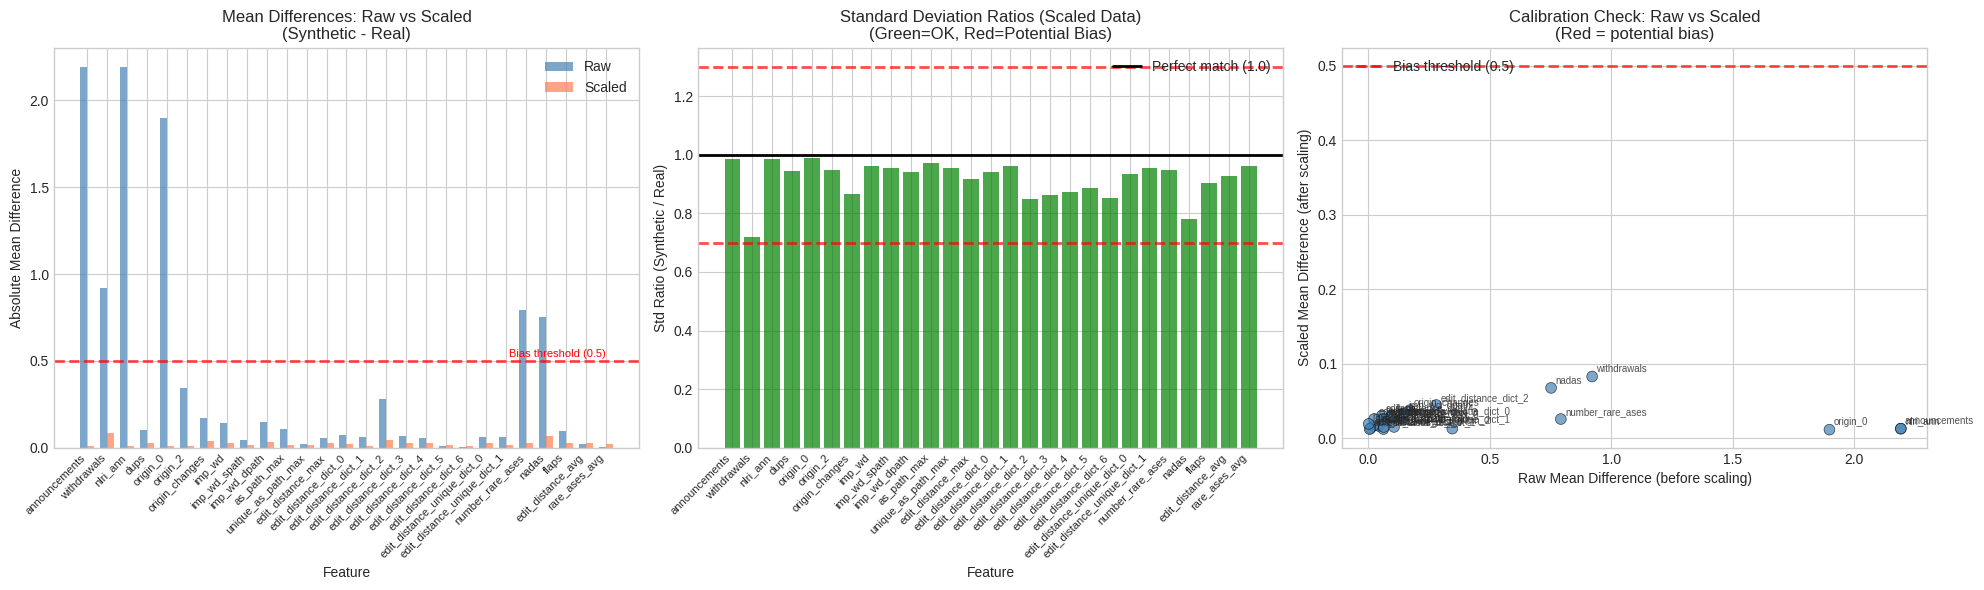

Saved: /home/smotaali/BGP_Traffic_Generation/results/SMOTE_enhanced/kmeans_v3_rrc04//calibration_check_visualization.png


In [213]:
# Visualize calibration check with feature names
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Get feature names for x-axis
feature_names = calibration_df_raw['feature'].tolist()
x_pos = np.arange(len(feature_names))
width = 0.35

# Plot 1: Mean differences (raw vs scaled)
ax1 = axes[0]
ax1.bar(x_pos - width/2, calibration_df_raw['mean_diff_raw'], width, label='Raw', alpha=0.7, color='steelblue')
ax1.bar(x_pos + width/2, calibration_df_raw['mean_diff_scaled'], width, label='Scaled', alpha=0.7, color='coral')
ax1.set_xlabel('Feature')
ax1.set_ylabel('Absolute Mean Difference')
ax1.set_title('Mean Differences: Raw vs Scaled\n(Synthetic - Real)')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(feature_names, rotation=45, ha='right', fontsize=8)
ax1.axhline(y=BIAS_THRESHOLD_MEAN, color='r', linestyle='--', alpha=0.7, linewidth=2)
ax1.legend(loc='upper right')
ax1.text(len(feature_names)-1, BIAS_THRESHOLD_MEAN + 0.02, f'Bias threshold ({BIAS_THRESHOLD_MEAN})', 
         fontsize=8, color='red', ha='right')

# Plot 2: Std ratios with feature names
ax2 = axes[1]
# Color bars based on whether they're within acceptable range
colors = ['green' if abs(r - 1.0) <= BIAS_THRESHOLD_STD else 'red' 
          for r in calibration_df_raw['std_ratio_scaled']]
ax2.bar(x_pos, calibration_df_raw['std_ratio_scaled'], alpha=0.7, color=colors)
ax2.axhline(y=1.0, color='black', linestyle='-', linewidth=2, label='Perfect match (1.0)')
ax2.axhline(y=1.0 + BIAS_THRESHOLD_STD, color='r', linestyle='--', alpha=0.7, linewidth=2)
ax2.axhline(y=1.0 - BIAS_THRESHOLD_STD, color='r', linestyle='--', alpha=0.7, linewidth=2)
ax2.set_xlabel('Feature')
ax2.set_ylabel('Std Ratio (Synthetic / Real)')
ax2.set_title('Standard Deviation Ratios (Scaled Data)\n(Green=OK, Red=Potential Bias)')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(feature_names, rotation=45, ha='right', fontsize=8)
ax2.legend(loc='upper right')

# Plot 3: Scatter of raw vs scaled mean differences with feature labels
ax3 = axes[2]
# Color points based on bias status
colors_scatter = ['red' if (row['potential_mean_bias'] or row['potential_std_bias']) else 'steelblue' 
                  for _, row in calibration_df_raw.iterrows()]
ax3.scatter(calibration_df_raw['mean_diff_raw'], calibration_df_raw['mean_diff_scaled'], 
            alpha=0.7, c=colors_scatter, s=60, edgecolors='black', linewidths=0.5)
ax3.set_xlabel('Raw Mean Difference (before scaling)')
ax3.set_ylabel('Scaled Mean Difference (after scaling)')
ax3.set_title('Calibration Check: Raw vs Scaled\n(Red = potential bias)')
ax3.axhline(y=BIAS_THRESHOLD_MEAN, color='r', linestyle='--', alpha=0.7, linewidth=2, 
            label=f'Bias threshold ({BIAS_THRESHOLD_MEAN})')

# Add feature labels for ALL points (not just outliers)
for idx, row in calibration_df_raw.iterrows():
    ax3.annotate(row['feature'], 
                 (row['mean_diff_raw'], row['mean_diff_scaled']),
                 fontsize=7, alpha=0.8,
                 xytext=(3, 3), textcoords='offset points')

ax3.legend(loc='upper left')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/calibration_check_visualization.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/calibration_check_visualization.png")

## 4. Descriptive Statistics Comparison

In [214]:
# Calculate descriptive statistics for both datasets
stats_synthetic = df_synthetic.describe().T
stats_real = df_real.describe().T

# Rename columns for clarity
stats_synthetic.columns = [f'syn_{col}' for col in stats_synthetic.columns]
stats_real.columns = [f'real_{col}' for col in stats_real.columns]

# Combine into comparison table
stats_comparison = pd.concat([stats_synthetic, stats_real], axis=1)

# Reorder columns for side-by-side comparison
ordered_cols = []
for stat in ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']:
    ordered_cols.extend([f'syn_{stat}', f'real_{stat}'])
stats_comparison = stats_comparison[ordered_cols]
stats_comparison.to_csv(f'{OUTPUT_DIR}/enhanced_v3_descriptive_stats.csv')

print("Descriptive Statistics Comparison (Synthetic vs Real)")
print("=" * 80)
stats_comparison

Descriptive Statistics Comparison (Synthetic vs Real)


,syn_count,real_count,syn_mean,real_mean,syn_std,real_std,syn_min,real_min,syn_25%,real_25%,syn_50%,real_50%,syn_75%,real_75%,syn_max,real_max
announcements,19994.0,19994.0,106.840052,109.032060,168.426544,170.756677,1.000000,1.0,20.000000,21.000000,42.000000,44.000000,99.000000,101.000000,1119.000000,1379.0
withdrawals,19994.0,19994.0,4.942933,5.864709,9.158343,12.754689,0.000000,0.0,1.000000,1.000000,2.000000,2.000000,6.000000,7.000000,217.000000,239.0
nlri_ann,19994.0,19994.0,106.840052,109.032060,168.426544,170.756677,1.000000,1.0,20.000000,21.000000,42.000000,44.000000,99.000000,101.000000,1119.000000,1379.0
dups,19994.0,19994.0,2.066370,2.168200,3.775902,3.993989,0.000000,0.0,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,37.000000,46.0
origin_0,19994.0,19994.0,87.762279,89.660598,162.740162,164.651343,0.000000,0.0,11.000000,11.000000,24.000000,26.000000,74.000000,74.000000,1096.000000,1333.0
origin_2,19994.0,19994.0,18.909323,19.255627,25.997017,27.447747,0.000000,0.0,6.000000,6.000000,11.000000,11.000000,22.000000,22.000000,349.000000,454.0
origin_changes,19994.0,19994.0,3.019556,3.190907,4.202481,4.852686,0.000000,0.0,1.000000,1.000000,2.000000,2.000000,3.000000,4.000000,68.000000,70.0
imp_wd,19994.0,19994.0,4.482995,4.623087,5.223992,5.427780,0.000000,0.0,1.000000,1.000000,3.000000,3.000000,6.000000,6.000000,58.000000,80.0
imp_wd_spath,19994.0,19994.0,1.142293,1.185806,2.570724,2.692392,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,35.000000,39.0
imp_wd_dpath,19994.0,19994.0,3.289537,3.437281,4.250172,4.523456,0.000000,0.0,1.000000,1.000000,2.000000,2.000000,4.000000,5.000000,54.000000,77.0


In [215]:
# IMPROVED: Mean Difference Analysis with better edge case handling
mean_diff = pd.DataFrame({
    'synthetic_mean': df_synthetic.mean(),
    'real_mean': df_real.mean()
})
mean_diff['abs_diff'] = abs(mean_diff['synthetic_mean'] - mean_diff['real_mean'])

# Handle edge cases where real_mean is near zero
MIN_MEANINGFUL_VALUE = 0.01
mean_diff['pct_diff'] = np.where(
    mean_diff['real_mean'].abs() > MIN_MEANINGFUL_VALUE,
    (mean_diff['abs_diff'] / mean_diff['real_mean'].abs()) * 100,
    np.where(
        mean_diff['abs_diff'] < MIN_MEANINGFUL_VALUE,
        0.0,  # Both near zero = no meaningful difference
        np.nan  # Real is ~0 but synthetic is not = undefined percentage
    )
)

mean_diff = mean_diff.sort_values('pct_diff', ascending=False)
mean_diff.to_csv(f'{OUTPUT_DIR}/enhanced_v3_mean_diff.csv')

print("\nMean Difference Analysis (sorted by % difference)")
print("=" * 60)
print(mean_diff.round(4))


Mean Difference Analysis (sorted by % difference)
                             synthetic_mean  real_mean  abs_diff  pct_diff
withdrawals                          4.9429     5.8647    0.9218   15.7173
nadas                                5.5132     6.2660    0.7528   12.0144
edit_distance_dict_2                 3.6549     3.9352    0.2803    7.1225
edit_distance_dict_4                 0.7584     0.8152    0.0568    6.9636
edit_distance_dict_6                 0.0915     0.0976    0.0061    6.2532
flaps                                1.6419     1.7388    0.0969    5.5715
origin_changes                       3.0196     3.1909    0.1714    5.3700
dups                                 2.0664     2.1682    0.1018    4.6965
edit_distance_dict_3                 1.5659     1.6367    0.0708    4.3270
imp_wd_dpath                         3.2895     3.4373    0.1477    4.2983
edit_distance_dict_5                 0.2149     0.2245    0.0096    4.2558
edit_distance_unique_dict_0          1.4226     1

## 5. Distribution Comparison (KS-Test + Wasserstein Distance)

In [216]:
# Perform Kolmogorov-Smirnov test with Wasserstein Distance
ks_results = []

for col in feature_cols:
    # KS Test
    ks_stat, ks_pvalue = stats.ks_2samp(df_synthetic[col], df_real[col])
    
    # Wasserstein Distance (Earth Mover's Distance)
    syn_normalized = (df_synthetic[col] - df_synthetic[col].mean()) / (df_synthetic[col].std() + 1e-10)
    real_normalized = (df_real[col] - df_real[col].mean()) / (df_real[col].std() + 1e-10)
    wd = wasserstein_distance(syn_normalized, real_normalized)
    
    # Use KS statistic threshold for large samples
    if ks_stat < KS_EXCELLENT_THRESHOLD:
        similarity_level = 'Excellent'
    elif ks_stat < KS_GOOD_THRESHOLD:
        similarity_level = 'Good'
    elif ks_stat < KS_MODERATE_THRESHOLD:
        similarity_level = 'Moderate'
    else:
        similarity_level = 'Poor'
    
    # Get feature importance weight
    weight = FEATURE_IMPORTANCE_WEIGHTS.get(col, FEATURE_IMPORTANCE_WEIGHTS['_default'])
    
    ks_results.append({
        'feature': col,
        'ks_statistic': ks_stat,
        'ks_pvalue': ks_pvalue,
        'wasserstein_distance': wd,
        'similarity_level': similarity_level,
        'similar_by_threshold': ks_stat < KS_GOOD_THRESHOLD,
        'importance_weight': weight
    })

ks_df = pd.DataFrame(ks_results)

# Apply multiple testing correction (FDR - Benjamini-Hochberg)
_, adjusted_pvalues, _, _ = multipletests(ks_df['ks_pvalue'], method='fdr_bh')
ks_df['adjusted_pvalue'] = adjusted_pvalues
ks_df['similar_by_adjusted_pvalue'] = adjusted_pvalues > ALPHA

ks_df = ks_df.sort_values('ks_statistic', ascending=False)
ks_df.to_csv(f'{OUTPUT_DIR}/enhanced_v3_ks_results.csv', index=False)

print("\nKolmogorov-Smirnov Test Results (with Feature Importance Weights)")
print("=" * 80)
print(f"\nBy KS Statistic Threshold (recommended for large N):")
print(f"   Excellent (KS < {KS_EXCELLENT_THRESHOLD}): {(ks_df['similarity_level'] == 'Excellent').sum()}/{len(feature_cols)}")
print(f"   Good (KS < {KS_GOOD_THRESHOLD}): {(ks_df['similarity_level'].isin(['Excellent', 'Good'])).sum()}/{len(feature_cols)}")
print(f"   Moderate (KS < {KS_MODERATE_THRESHOLD}): {(ks_df['similarity_level'].isin(['Excellent', 'Good', 'Moderate'])).sum()}/{len(feature_cols)}")
print(f"\nBy Adjusted P-value (FDR corrected):")
print(f"   Similar distributions: {ks_df['similar_by_adjusted_pvalue'].sum()}/{len(feature_cols)}")
print(f"\nWasserstein Distance (lower = more similar):")
print(f"   Mean: {ks_df['wasserstein_distance'].mean():.4f}")
print(f"   Median: {ks_df['wasserstein_distance'].median():.4f}")
print("\n")
print(ks_df.to_string(index=False))


Kolmogorov-Smirnov Test Results (with Feature Importance Weights)

By KS Statistic Threshold (recommended for large N):
   Excellent (KS < 0.05): 26/27
   Good (KS < 0.1): 27/27
   Moderate (KS < 0.15): 27/27

By Adjusted P-value (FDR corrected):
   Similar distributions: 5/27

Wasserstein Distance (lower = more similar):
   Mean: 0.0488
   Median: 0.0445


                    feature  ks_statistic    ks_pvalue  wasserstein_distance similarity_level  similar_by_threshold  importance_weight  adjusted_pvalue  similar_by_adjusted_pvalue
          edit_distance_avg      0.058818 1.665558e-30              0.034013             Good                  True                1.0     4.497007e-29                       False
       edit_distance_dict_2      0.045264 3.090045e-18              0.055041        Excellent                  True                1.0     4.171561e-17                       False
                      flaps      0.043413 8.253772e-17              0.069169        Excellent      

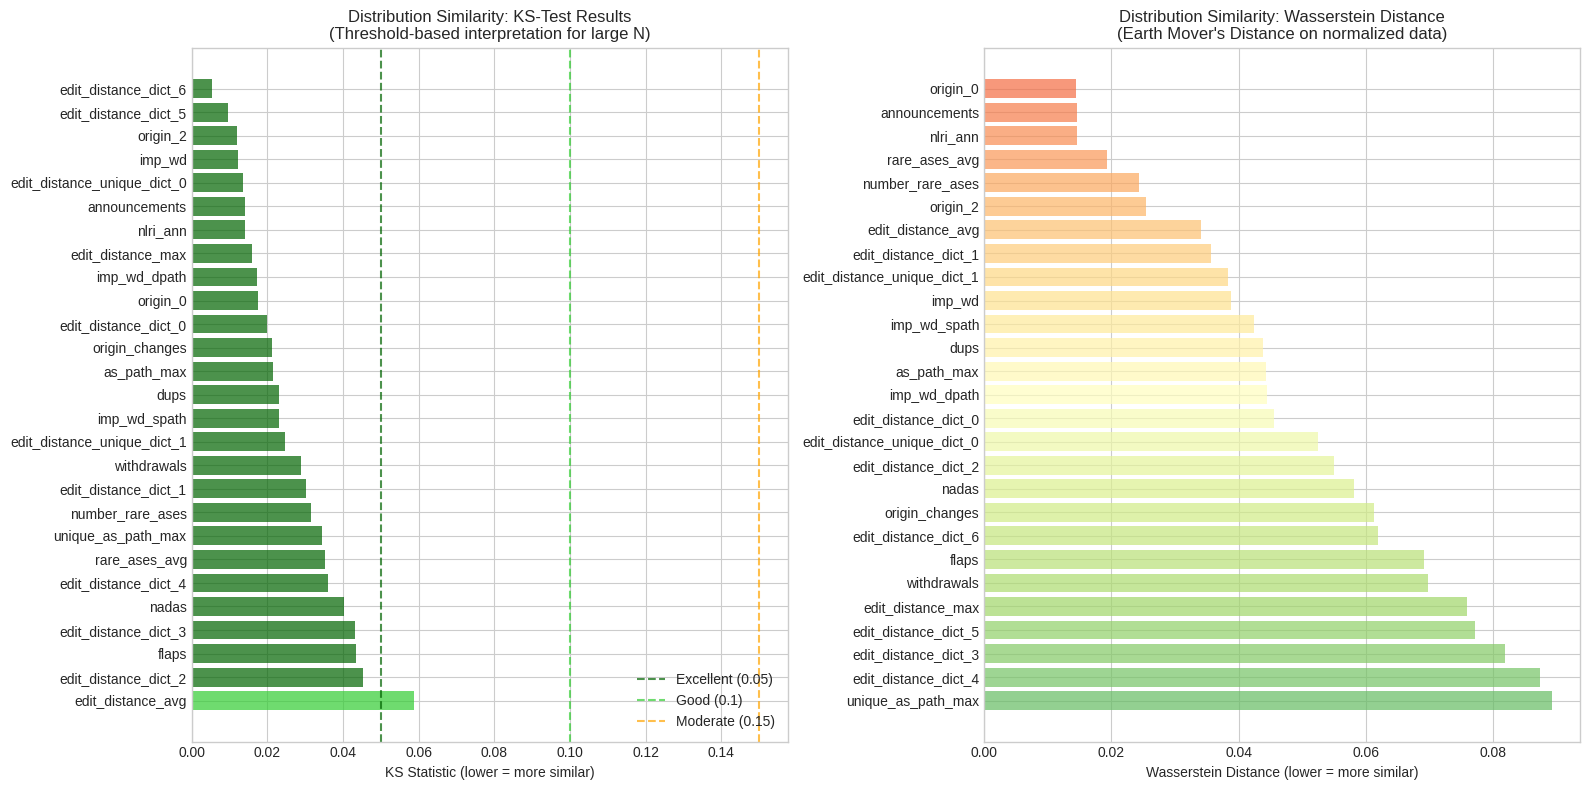

Saved: /home/smotaali/BGP_Traffic_Generation/results/SMOTE_enhanced/kmeans_v3_rrc04//enhanced_v3_distribution_tests.png


In [217]:
# Visualize KS statistics with improved interpretation
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Left plot: KS Statistics
ax1 = axes[0]
colors_ks = {
    'Excellent': 'darkgreen',
    'Good': 'limegreen',
    'Moderate': 'orange',
    'Poor': 'red'
}
bar_colors = [colors_ks[level] for level in ks_df['similarity_level']]
bars = ax1.barh(ks_df['feature'], ks_df['ks_statistic'], color=bar_colors, alpha=0.7)

ax1.axvline(x=KS_EXCELLENT_THRESHOLD, color='darkgreen', linestyle='--', alpha=0.7, label=f'Excellent ({KS_EXCELLENT_THRESHOLD})')
ax1.axvline(x=KS_GOOD_THRESHOLD, color='limegreen', linestyle='--', alpha=0.7, label=f'Good ({KS_GOOD_THRESHOLD})')
ax1.axvline(x=KS_MODERATE_THRESHOLD, color='orange', linestyle='--', alpha=0.7, label=f'Moderate ({KS_MODERATE_THRESHOLD})')
ax1.set_xlabel('KS Statistic (lower = more similar)')
ax1.set_title('Distribution Similarity: KS-Test Results\n(Threshold-based interpretation for large N)')
ax1.legend(loc='lower right')

# Right plot: Wasserstein Distance
ax2 = axes[1]
ks_df_sorted_wd = ks_df.sort_values('wasserstein_distance', ascending=False)
colors_wd = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(ks_df_sorted_wd)))
ax2.barh(ks_df_sorted_wd['feature'], ks_df_sorted_wd['wasserstein_distance'], color=colors_wd, alpha=0.7)
ax2.set_xlabel('Wasserstein Distance (lower = more similar)')
ax2.set_title("Distribution Similarity: Wasserstein Distance\n(Earth Mover's Distance on normalized data)")

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/enhanced_v3_distribution_tests.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/enhanced_v3_distribution_tests.png")

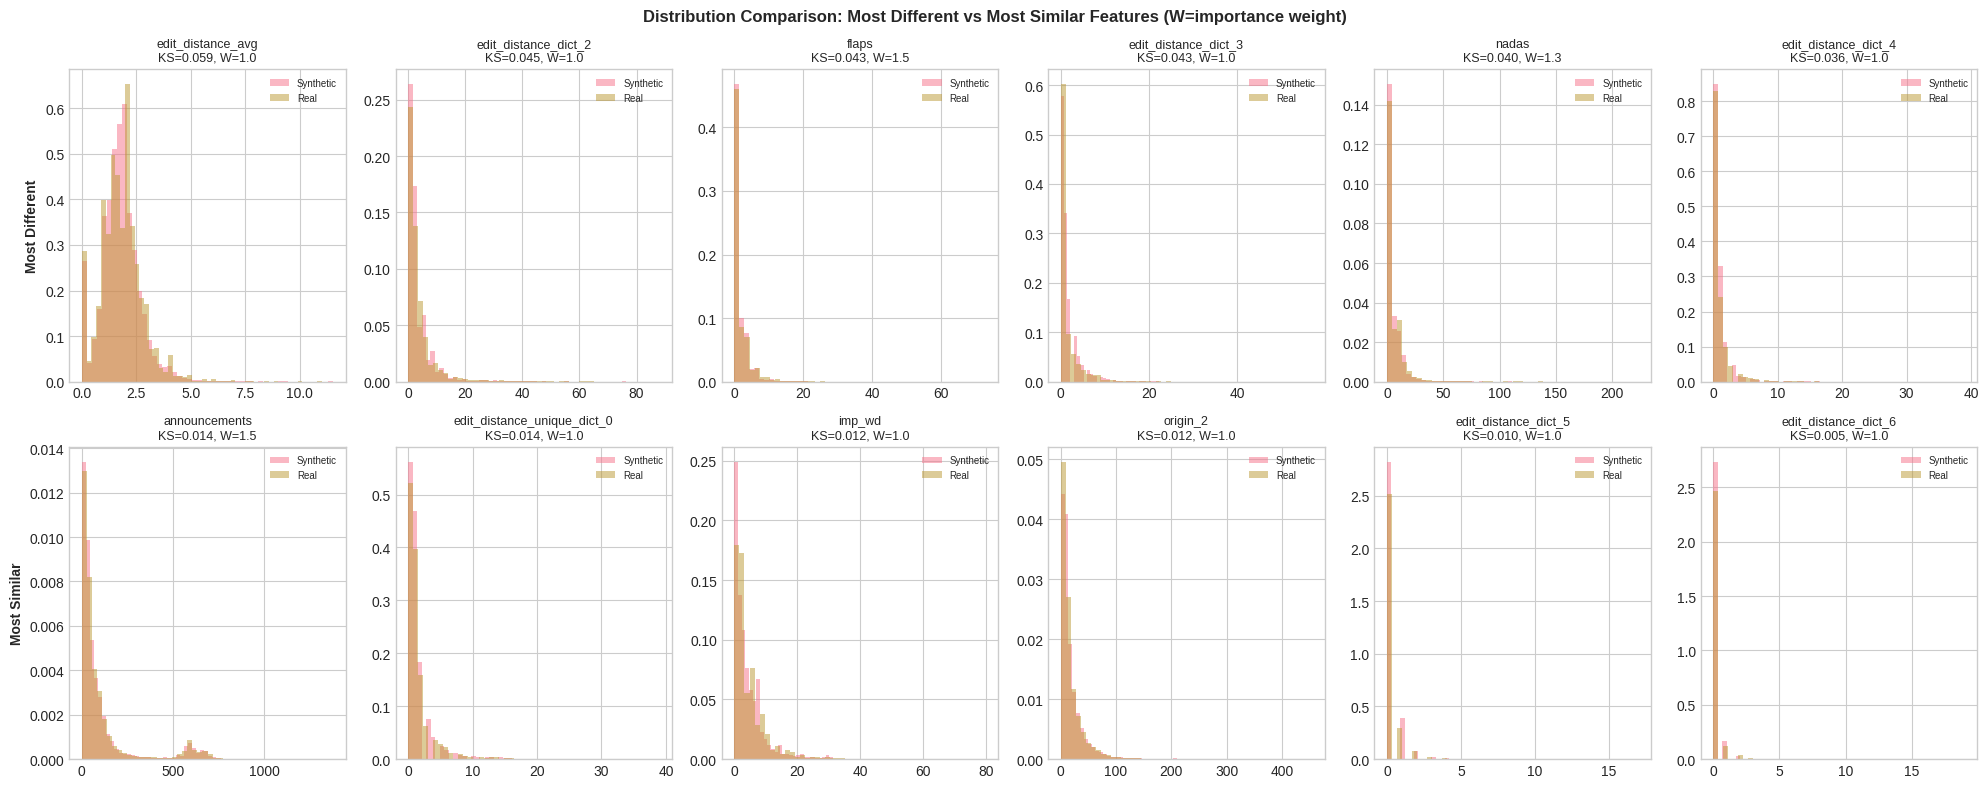

Saved: /home/smotaali/BGP_Traffic_Generation/results/SMOTE_enhanced/kmeans_v3_rrc04//enhanced_v3_distribution_comparison.png


In [218]:
# Plot distributions for selected features
n_features_to_plot = 6

# Most different (highest KS statistic)
most_different = ks_df.head(n_features_to_plot)['feature'].tolist()
# Most similar (lowest KS statistic)
most_similar = ks_df.tail(n_features_to_plot)['feature'].tolist()

fig, axes = plt.subplots(2, n_features_to_plot, figsize=(20, 8))

# Plot most different
for i, col in enumerate(most_different):
    ax = axes[0, i]
    ax.hist(df_synthetic[col], bins=50, alpha=0.5, label='Synthetic', density=True)
    ax.hist(df_real[col], bins=50, alpha=0.5, label='Real', density=True)
    ks_val = ks_df[ks_df['feature'] == col]['ks_statistic'].values[0]
    weight = ks_df[ks_df['feature'] == col]['importance_weight'].values[0]
    ax.set_title(f'{col}\nKS={ks_val:.3f}, W={weight:.1f}', fontsize=9)
    ax.legend(fontsize=7)
    if i == 0:
        ax.set_ylabel('Most Different', fontsize=10, fontweight='bold')

# Plot most similar
for i, col in enumerate(most_similar):
    ax = axes[1, i]
    ax.hist(df_synthetic[col], bins=50, alpha=0.5, label='Synthetic', density=True)
    ax.hist(df_real[col], bins=50, alpha=0.5, label='Real', density=True)
    ks_val = ks_df[ks_df['feature'] == col]['ks_statistic'].values[0]
    weight = ks_df[ks_df['feature'] == col]['importance_weight'].values[0]
    ax.set_title(f'{col}\nKS={ks_val:.3f}, W={weight:.1f}', fontsize=9)
    ax.legend(fontsize=7)
    if i == 0:
        ax.set_ylabel('Most Similar', fontsize=10, fontweight='bold')

plt.suptitle('Distribution Comparison: Most Different vs Most Similar Features (W=importance weight)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/enhanced_v3_distribution_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/enhanced_v3_distribution_comparison.png")

## 6. Correlation Structure Analysis

In [219]:
# Calculate correlation matrices
corr_synthetic = df_synthetic.corr()
corr_real = df_real.corr()

# Absolute difference in correlations
corr_diff = abs(corr_synthetic - corr_real)

print("Correlation Matrix Comparison")
print("=" * 60)
print(f"Mean absolute correlation difference: {corr_diff.values.mean():.4f}")
print(f"Max absolute correlation difference: {corr_diff.values.max():.4f}")
print(f"Median absolute correlation difference: {np.median(corr_diff.values):.4f}")

Correlation Matrix Comparison
Mean absolute correlation difference: 0.0214
Max absolute correlation difference: 0.1164
Median absolute correlation difference: 0.0171


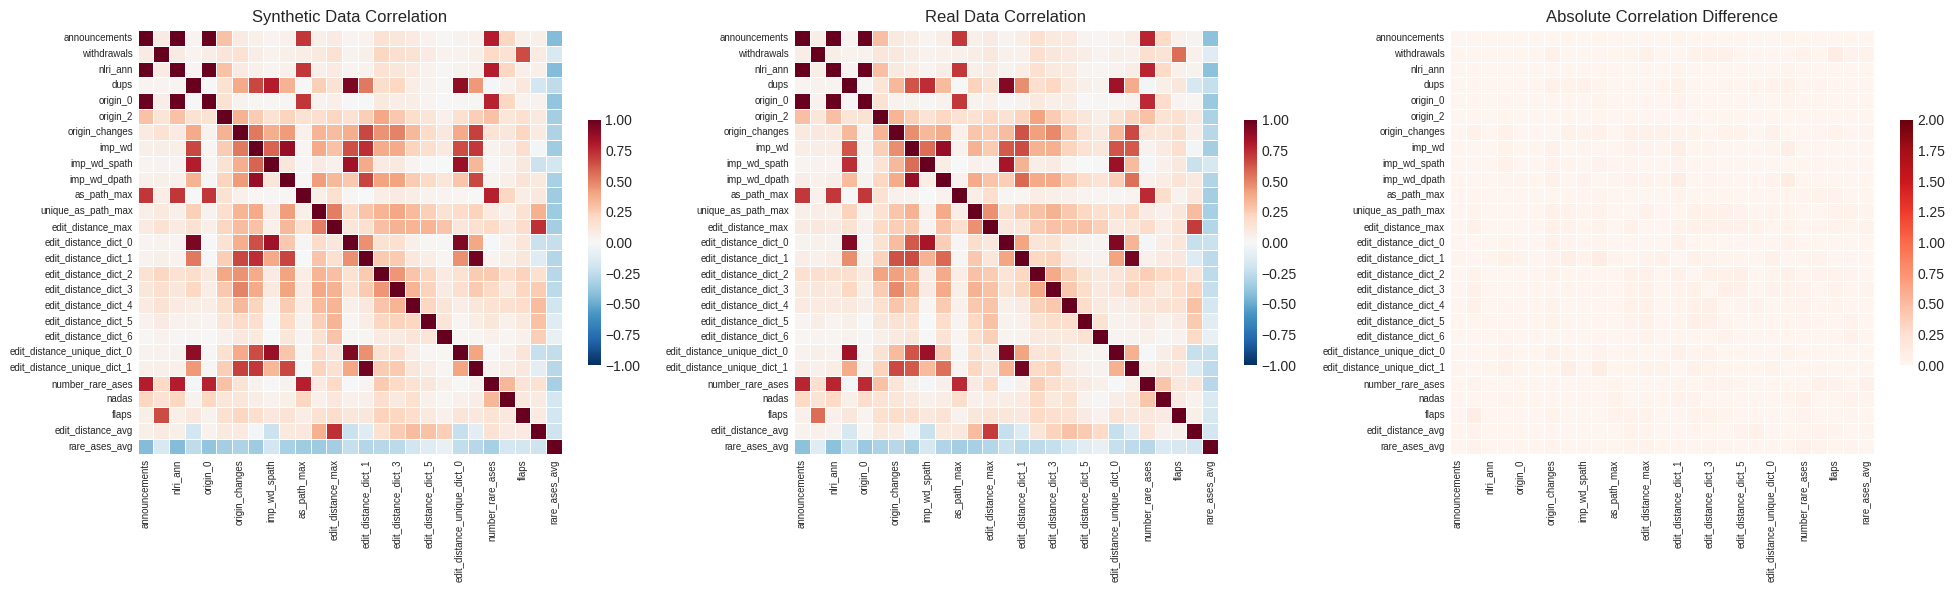

Saved: /home/smotaali/BGP_Traffic_Generation/results/SMOTE_enhanced/kmeans_v3_rrc04//enhanced_v3_correlation_comparison.png


In [220]:
# Plot correlation matrices side by side
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Synthetic correlation
sns.heatmap(corr_synthetic, ax=axes[0], cmap='RdBu_r', center=0, 
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.5},
            vmin=-1, vmax=1)
axes[0].set_title('Synthetic Data Correlation', fontsize=12)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, fontsize=7)
axes[0].set_yticklabels(axes[0].get_yticklabels(), fontsize=7)

# Real correlation
sns.heatmap(corr_real, ax=axes[1], cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.5},
            vmin=-1, vmax=1)
axes[1].set_title('Real Data Correlation', fontsize=12)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90, fontsize=7)
axes[1].set_yticklabels(axes[1].get_yticklabels(), fontsize=7)

# Difference
sns.heatmap(corr_diff, ax=axes[2], cmap='Reds',
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.5},
            vmin=0, vmax=2)
axes[2].set_title('Absolute Correlation Difference', fontsize=12)
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=90, fontsize=7)
axes[2].set_yticklabels(axes[2].get_yticklabels(), fontsize=7)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/enhanced_v3_correlation_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/enhanced_v3_correlation_comparison.png")

In [221]:
# Correlation of correlations (how similar are the correlation structures?)
def get_upper_triangle(matrix):
    return matrix.values[np.triu_indices(len(matrix), k=1)]

corr_syn_flat = get_upper_triangle(corr_synthetic)
corr_real_flat = get_upper_triangle(corr_real)

# Calculate correlation between correlation structures
structure_corr, structure_p = stats.pearsonr(corr_syn_flat, corr_real_flat)

# Also calculate Spearman (rank-based) correlation
structure_spearman, spearman_p = stats.spearmanr(corr_syn_flat, corr_real_flat)

print(f"\nCorrelation Structure Similarity")
print("=" * 40)
print(f"Pearson correlation of correlation matrices: {structure_corr:.4f}")
print(f"Spearman correlation of correlation matrices: {structure_spearman:.4f}")
print(f"\nInterpretation: {'High' if structure_corr > 0.8 else 'Moderate' if structure_corr > 0.5 else 'Low'} structural similarity")

# Warn if correlation is negative (anti-aligned structures)
if structure_corr < 0:
    print(f"\n[WARNING] Negative correlation ({structure_corr:.4f}) indicates anti-aligned structures!")
    print(f"   This suggests the GAN may be learning inverted relationships.")


Correlation Structure Similarity
Pearson correlation of correlation matrices: 0.9960
Spearman correlation of correlation matrices: 0.9869

Interpretation: High structural similarity


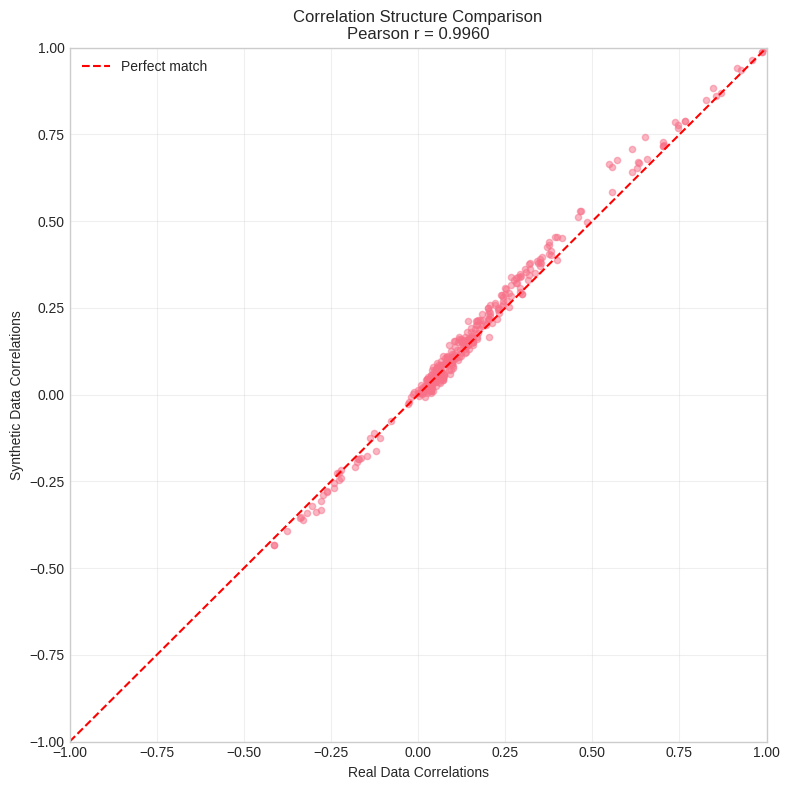

Saved: /home/smotaali/BGP_Traffic_Generation/results/SMOTE_enhanced/kmeans_v3_rrc04//enhanced_v3_correlation_scatter.png


In [222]:
# Scatter plot of correlations
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(corr_real_flat, corr_syn_flat, alpha=0.5, s=20)
ax.plot([-1, 1], [-1, 1], 'r--', label='Perfect match')
ax.set_xlabel('Real Data Correlations')
ax.set_ylabel('Synthetic Data Correlations')
ax.set_title(f'Correlation Structure Comparison\nPearson r = {structure_corr:.4f}')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/enhanced_v3_correlation_scatter.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/enhanced_v3_correlation_scatter.png")

## 7. Statistical Tests and Effect Sizes

In [223]:
# Mann-Whitney U test (non-parametric alternative to t-test)
mw_results = []

for col in feature_cols:
    stat, p_value = stats.mannwhitneyu(df_synthetic[col], df_real[col], alternative='two-sided')
    weight = FEATURE_IMPORTANCE_WEIGHTS.get(col, FEATURE_IMPORTANCE_WEIGHTS['_default'])
    mw_results.append({
        'feature': col,
        'mw_statistic': stat,
        'p_value': p_value,
        'importance_weight': weight
    })

mw_df = pd.DataFrame(mw_results)

# Apply FDR correction to Mann-Whitney results
_, mw_adjusted_pvalues, _, _ = multipletests(mw_df['p_value'], method='fdr_bh')
mw_df['adjusted_p_value'] = mw_adjusted_pvalues
mw_df['similar'] = mw_adjusted_pvalues > ALPHA

mw_df = mw_df.sort_values('p_value', ascending=True)
mw_df.to_csv(f'{OUTPUT_DIR}/enhanced_v3_mw_results.csv', index=False)

print("Mann-Whitney U Test Results (with FDR correction)")
print("=" * 60)
print(f"Features with similar medians (adjusted p > {ALPHA}): {mw_df['similar'].sum()}/{len(feature_cols)}")
print("\n")
print(mw_df.to_string(index=False))

Mann-Whitney U Test Results (with FDR correction)
Features with similar medians (adjusted p > 0.05): 20/27


                    feature  mw_statistic      p_value  importance_weight  adjusted_p_value  similar
              rare_ases_avg   205857782.0 2.228861e-07                1.0          0.000006    False
       edit_distance_dict_3   205202765.5 1.079624e-06                1.0          0.000015    False
       edit_distance_dict_4   204629756.0 1.738678e-06                1.0          0.000016    False
                      flaps   204986710.0 3.786361e-06                1.5          0.000026    False
         unique_as_path_max   204479933.5 3.958203e-05                1.0          0.000214    False
       edit_distance_dict_2   203166470.5 3.952734e-03                1.0          0.017787    False
               imp_wd_spath   202581303.5 1.046621e-02                1.0          0.040370    False
       edit_distance_dict_5   201505376.0 2.230849e-02                1.0          

In [224]:
# Cohen's d effect size with capping for numeric stability
def cohens_d(group1, group2, cap=COHENS_D_CAP):
    """
    Calculate Cohen's d effect size with proper handling of edge cases.
    """
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    
    if pooled_std == 0:
        if group1.mean() == group2.mean():
            return 0.0
        else:
            return cap if group1.mean() > group2.mean() else -cap
    
    d = (group1.mean() - group2.mean()) / pooled_std
    return np.clip(d, -cap, cap)

effect_sizes = []
for col in feature_cols:
    d = cohens_d(df_synthetic[col], df_real[col])
    weight = FEATURE_IMPORTANCE_WEIGHTS.get(col, FEATURE_IMPORTANCE_WEIGHTS['_default'])
    
    abs_d = abs(d)
    if abs_d < 0.2:
        interpretation = 'Negligible'
    elif abs_d < 0.5:
        interpretation = 'Small'
    elif abs_d < 0.8:
        interpretation = 'Medium'
    else:
        interpretation = 'Large'
    
    effect_sizes.append({
        'feature': col,
        'cohens_d': d,
        'abs_d': abs_d,
        'interpretation': interpretation,
        'capped': abs_d >= COHENS_D_CAP,
        'importance_weight': weight
    })

effect_df = pd.DataFrame(effect_sizes).sort_values('abs_d', ascending=False)
effect_df.to_csv(f'{OUTPUT_DIR}/enhanced_v3_effect_sizes.csv', index=False)

print("Cohen's d Effect Size Analysis (with Feature Importance Weights)")
print("=" * 60)
print(f"\nEffect Size Distribution:")
print(effect_df['interpretation'].value_counts())

# Warn about capped values
n_capped = effect_df['capped'].sum()
if n_capped > 0:
    print(f"\n[WARNING] {n_capped} feature(s) had Cohen's d capped at +/-{COHENS_D_CAP}")
    print(f"   Features: {effect_df[effect_df['capped']]['feature'].tolist()}")

print("\n")
print(effect_df.to_string(index=False))

Cohen's d Effect Size Analysis (with Feature Importance Weights)

Effect Size Distribution:
interpretation
Negligible    27
Name: count, dtype: int64


                    feature  cohens_d    abs_d interpretation  capped  importance_weight
                withdrawals -0.083020 0.083020     Negligible   False                1.5
                      nadas -0.067695 0.067695     Negligible   False                1.3
       edit_distance_dict_2 -0.044704 0.044704     Negligible   False                1.0
             origin_changes -0.037749 0.037749     Negligible   False                1.0
               imp_wd_dpath -0.033663 0.033663     Negligible   False                1.0
       edit_distance_dict_4 -0.030658 0.030658     Negligible   False                1.0
                      flaps -0.030362 0.030362     Negligible   False                1.5
                     imp_wd -0.026299 0.026299     Negligible   False                1.0
                       dups -0.026201 0.026201 

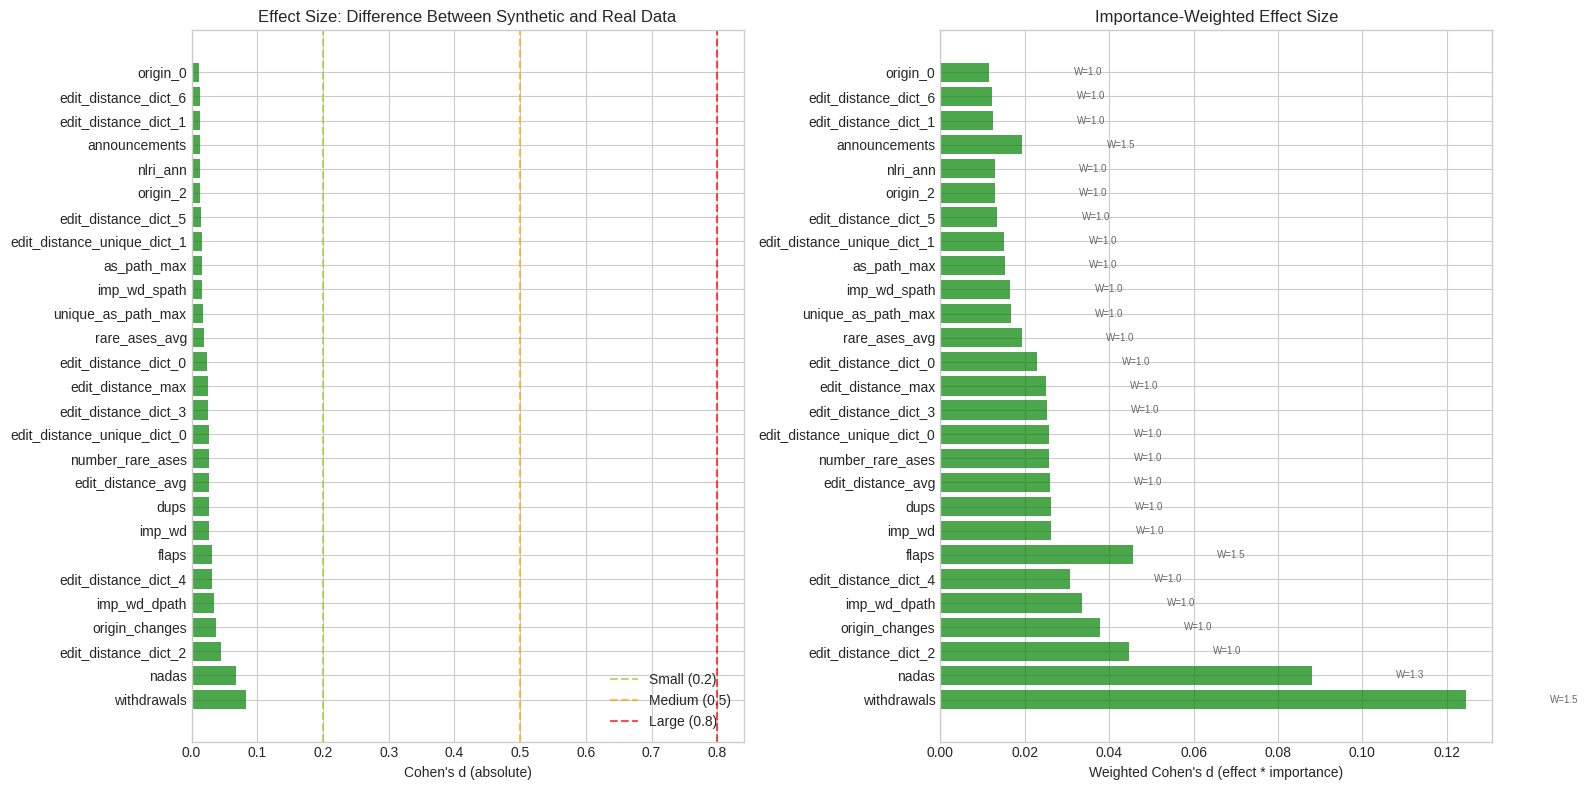

Saved: /home/smotaali/BGP_Traffic_Generation/results/SMOTE_enhanced/kmeans_v3_rrc04//enhanced_v3_effect_sizes.png


In [225]:
# Visualize effect sizes with importance weights
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Left plot: Effect sizes
ax1 = axes[0]
colors_effect = {
    'Negligible': 'green',
    'Small': 'yellowgreen', 
    'Medium': 'orange',
    'Large': 'red'
}
bar_colors = [colors_effect[interp] for interp in effect_df['interpretation']]

ax1.barh(effect_df['feature'], effect_df['abs_d'], color=bar_colors, alpha=0.7)
ax1.axvline(x=0.2, color='yellowgreen', linestyle='--', alpha=0.7, label='Small (0.2)')
ax1.axvline(x=0.5, color='orange', linestyle='--', alpha=0.7, label='Medium (0.5)')
ax1.axvline(x=0.8, color='red', linestyle='--', alpha=0.7, label='Large (0.8)')
ax1.set_xlabel("Cohen's d (absolute)")
ax1.set_title("Effect Size: Difference Between Synthetic and Real Data")
ax1.legend(loc='lower right')

# Right plot: Effect sizes weighted by importance
ax2 = axes[1]
weighted_effects = effect_df['abs_d'] * effect_df['importance_weight']
ax2.barh(effect_df['feature'], weighted_effects, color=bar_colors, alpha=0.7)
ax2.set_xlabel("Weighted Cohen's d (effect * importance)")
ax2.set_title("Importance-Weighted Effect Size")

# Add importance weight annotations
for i, (idx, row) in enumerate(effect_df.iterrows()):
    ax2.text(weighted_effects.iloc[i] + 0.02, i, f'W={row["importance_weight"]:.1f}', 
             va='center', fontsize=7, alpha=0.7)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/enhanced_v3_effect_sizes.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/enhanced_v3_effect_sizes.png")

## 8. Top-K Worst Features Analysis (BGP Semantics Mapping)

In [226]:
# =============================================================================
# ENHANCED: Top-K Worst Features Table
# =============================================================================
# This section identifies the features with the largest discrepancies between
# synthetic and real data, ranked by both KS statistic and Cohen's d.
# This helps link model weaknesses to BGP semantics for paper discussion.

print("=" * 80)
print(f"TOP-{TOP_K_WORST_FEATURES} WORST FEATURES ANALYSIS")
print("=" * 80)

# Combine metrics for comprehensive ranking
worst_features_df = ks_df[['feature', 'ks_statistic', 'wasserstein_distance', 'similarity_level', 'importance_weight']].merge(
    effect_df[['feature', 'cohens_d', 'abs_d', 'interpretation']], 
    on='feature'
)

# Add a composite badness score (weighted by importance)
# Higher is worse
worst_features_df['ks_weighted'] = worst_features_df['ks_statistic'] * worst_features_df['importance_weight']
worst_features_df['effect_weighted'] = worst_features_df['abs_d'] * worst_features_df['importance_weight']
worst_features_df['composite_score'] = (
    worst_features_df['ks_weighted'] * 0.5 + 
    worst_features_df['effect_weighted'] * 0.5
)

# Sort by composite score (worst first)
worst_features_ranked = worst_features_df.sort_values('composite_score', ascending=False)

print(f"\n--- Top {TOP_K_WORST_FEATURES} Worst Features by Composite Score ---")
print("(Composite = 0.5*KS_weighted + 0.5*Effect_weighted)")
print()

top_k_worst = worst_features_ranked.head(TOP_K_WORST_FEATURES)
print(top_k_worst[['feature', 'ks_statistic', 'abs_d', 'importance_weight', 
                   'composite_score', 'similarity_level', 'interpretation']].to_string(index=False))

# Save top-K worst features
top_k_worst.to_csv(f'{OUTPUT_DIR}/enhanced_v3_top_k_worst_features.csv', index=False)
print(f"\nSaved: {OUTPUT_DIR}/enhanced_v3_top_k_worst_features.csv")

TOP-10 WORST FEATURES ANALYSIS

--- Top 10 Worst Features by Composite Score ---
(Composite = 0.5*KS_weighted + 0.5*Effect_weighted)

             feature  ks_statistic    abs_d  importance_weight  composite_score similarity_level interpretation
         withdrawals      0.029009 0.083020                1.5         0.084021        Excellent     Negligible
               nadas      0.040312 0.067695                1.3         0.070205        Excellent     Negligible
               flaps      0.043413 0.030362                1.5         0.055332        Excellent     Negligible
edit_distance_dict_2      0.045264 0.044704                1.0         0.044984        Excellent     Negligible
   edit_distance_avg      0.058818 0.025994                1.0         0.042406             Good     Negligible
edit_distance_dict_3      0.043163 0.025281                1.0         0.034222        Excellent     Negligible
edit_distance_dict_4      0.036161 0.030658                1.0         0.033410   

In [227]:
# Detailed breakdown for paper discussion
print("\n" + "=" * 80)
print("DETAILED WORST FEATURES BREAKDOWN (for paper discussion)")
print("=" * 80)

for i, (idx, row) in enumerate(top_k_worst.iterrows()):
    print(f"\n{i+1}. {row['feature']}")
    print(f"   - KS Statistic: {row['ks_statistic']:.4f} ({row['similarity_level']})")
    print(f"   - Cohen's d: {row['cohens_d']:.4f} ({row['interpretation']})")
    print(f"   - Wasserstein Distance: {row['wasserstein_distance']:.4f}")
    print(f"   - Importance Weight: {row['importance_weight']:.1f}")
    print(f"   - Composite Score: {row['composite_score']:.4f}")
    
    # BGP semantic interpretation
    feature_name = row['feature'].lower()
    if 'announcement' in feature_name:
        print("   - BGP Semantic: Core routing update activity - critical for traffic realism")
    elif 'withdrawal' in feature_name:
        print("   - BGP Semantic: Route withdrawal patterns - important for instability detection")
    elif 'flap' in feature_name:
        print("   - BGP Semantic: Network instability indicator - key anomaly signature")
    elif 'nada' in feature_name:
        print("   - BGP Semantic: No-Advertise-to-Any policy - unusual routing behavior")
    elif 'rare_as' in feature_name:
        print("   - BGP Semantic: Unusual AS appearances - potential anomaly indicator")
    elif 'edit_dist' in feature_name:
        print("   - BGP Semantic: AS-path change magnitude - routing dynamics measure")
    elif 'prefix' in feature_name:
        print("   - BGP Semantic: Prefix diversity/activity - address space coverage")
    elif 'path' in feature_name:
        print("   - BGP Semantic: AS-path characteristics - routing topology indicator")
    else:
        print("   - BGP Semantic: General traffic characteristic")


DETAILED WORST FEATURES BREAKDOWN (for paper discussion)

1. withdrawals
   - KS Statistic: 0.0290 (Excellent)
   - Cohen's d: -0.0830 (Negligible)
   - Wasserstein Distance: 0.0697
   - Importance Weight: 1.5
   - Composite Score: 0.0840
   - BGP Semantic: Route withdrawal patterns - important for instability detection

2. nadas
   - KS Statistic: 0.0403 (Excellent)
   - Cohen's d: -0.0677 (Negligible)
   - Wasserstein Distance: 0.0580
   - Importance Weight: 1.3
   - Composite Score: 0.0702
   - BGP Semantic: No-Advertise-to-Any policy - unusual routing behavior

3. flaps
   - KS Statistic: 0.0434 (Excellent)
   - Cohen's d: -0.0304 (Negligible)
   - Wasserstein Distance: 0.0692
   - Importance Weight: 1.5
   - Composite Score: 0.0553
   - BGP Semantic: Network instability indicator - key anomaly signature

4. edit_distance_dict_2
   - KS Statistic: 0.0453 (Excellent)
   - Cohen's d: -0.0447 (Negligible)
   - Wasserstein Distance: 0.0550
   - Importance Weight: 1.0
   - Composite Sc

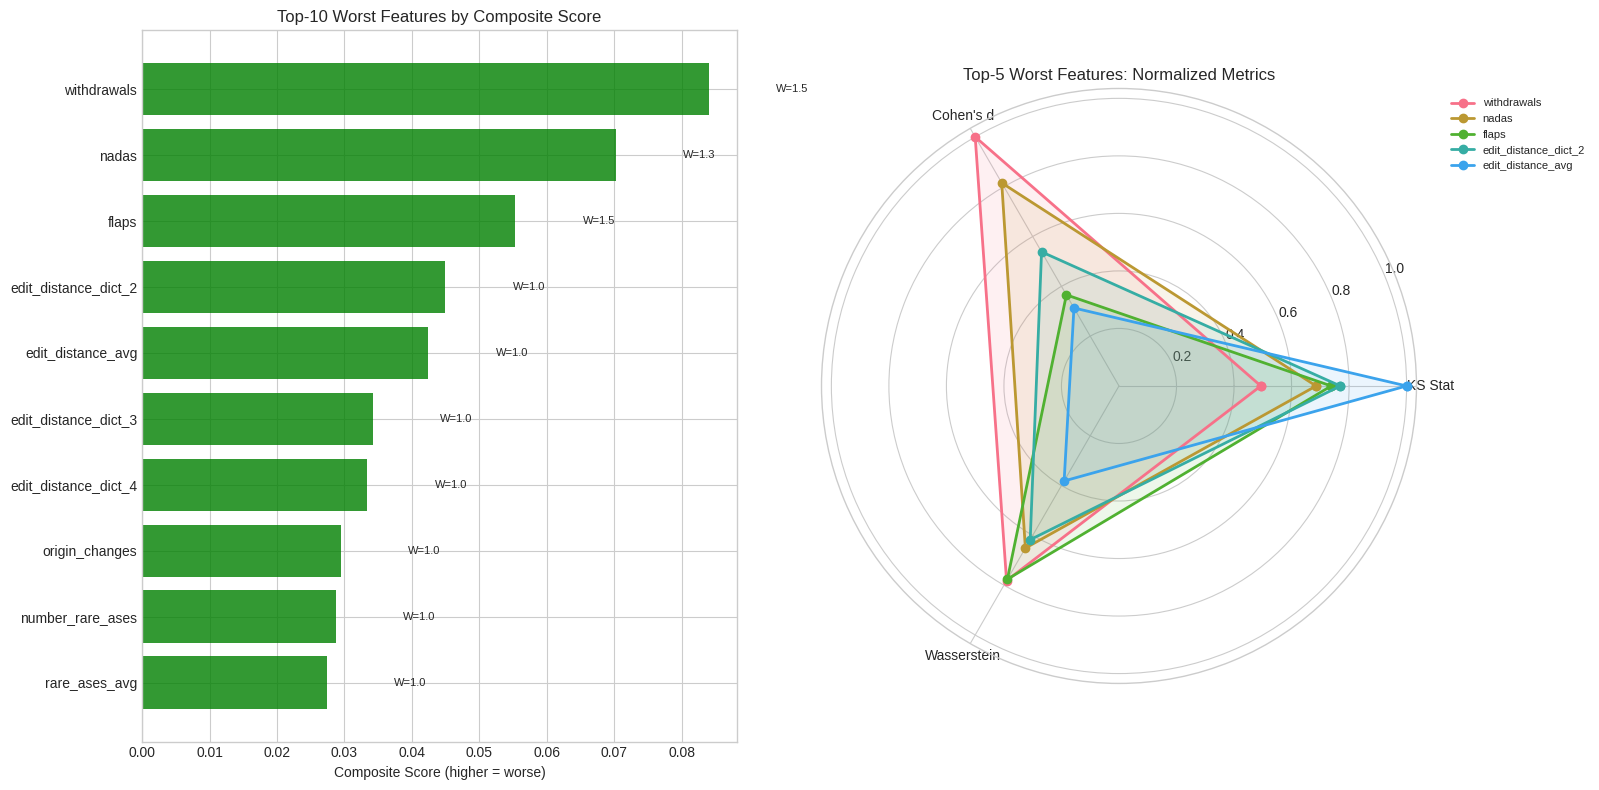

Saved: /home/smotaali/BGP_Traffic_Generation/results/SMOTE_enhanced/kmeans_v3_rrc04//enhanced_v3_top_k_worst_features.png


In [228]:
# Visualize top-K worst features
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Left: Bar chart of composite scores
ax1 = axes[0]
colors = ['red' if row['interpretation'] == 'Large' else 
          'orange' if row['interpretation'] == 'Medium' else 
          'yellowgreen' if row['interpretation'] == 'Small' else 'green'
          for _, row in top_k_worst.iterrows()]
bars = ax1.barh(top_k_worst['feature'], top_k_worst['composite_score'], color=colors, alpha=0.8)
ax1.set_xlabel('Composite Score (higher = worse)')
ax1.set_title(f'Top-{TOP_K_WORST_FEATURES} Worst Features by Composite Score')
ax1.invert_yaxis()

# Add weight annotations
for i, (idx, row) in enumerate(top_k_worst.iterrows()):
    ax1.text(row['composite_score'] + 0.01, i, f'W={row["importance_weight"]:.1f}', 
             va='center', fontsize=8)

# Right: Radar/spider chart for top 5
ax2 = axes[1]
top_5 = top_k_worst.head(5)

# Normalize metrics for radar chart
metrics = ['ks_statistic', 'abs_d', 'wasserstein_distance']
max_vals = {m: worst_features_df[m].max() for m in metrics}

angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

ax2 = plt.subplot(122, projection='polar')
for idx, row in top_5.iterrows():
    values = [row[m] / max_vals[m] for m in metrics]
    values += values[:1]
    ax2.plot(angles, values, 'o-', linewidth=2, label=row['feature'])
    ax2.fill(angles, values, alpha=0.1)

ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(['KS Stat', 'Cohen\'s d', 'Wasserstein'])
ax2.set_title('Top-5 Worst Features: Normalized Metrics')
ax2.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=8)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/enhanced_v3_top_k_worst_features.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/enhanced_v3_top_k_worst_features.png")

## 9. Multivariate Analysis (PCA Centroid Distance + t-SNE Overlay)

In [229]:
# Combine and scale data for dimensionality reduction
X_combined = np.vstack([X_synthetic, X_real])
labels = ['Synthetic'] * len(X_synthetic) + ['Real'] * len(X_real)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

# Split back for centroid calculation
X_syn_scaled = X_scaled[:len(X_synthetic)]
X_real_scaled = X_scaled[len(X_synthetic):]

print(f"Combined data shape: {X_combined.shape}")
print(f"Synthetic scaled shape: {X_syn_scaled.shape}")
print(f"Real scaled shape: {X_real_scaled.shape}")

Combined data shape: (39988, 27)
Synthetic scaled shape: (19994, 27)
Real scaled shape: (19994, 27)


In [230]:
# =============================================================================
# ENHANCED: PCA Centroid Distance Analysis
# =============================================================================
# Complement 1D tests with multivariate check: distance between centroids in PCA space

# Perform PCA
pca = PCA(n_components=min(10, len(feature_cols)))
X_pca_full = pca.fit_transform(X_scaled)

# Split back
X_pca_syn = X_pca_full[:len(X_synthetic)]
X_pca_real = X_pca_full[len(X_synthetic):]

# Calculate centroids in PCA space
centroid_syn = X_pca_syn.mean(axis=0)
centroid_real = X_pca_real.mean(axis=0)

# Euclidean distance between centroids
centroid_distance = np.linalg.norm(centroid_syn - centroid_real)

# Also calculate distance using only top-2 PCs (for visualization)
centroid_distance_2d = np.linalg.norm(centroid_syn[:2] - centroid_real[:2])

# Calculate Mahalanobis distance for more robust measure
# Use pooled covariance
cov_pooled = (np.cov(X_pca_syn.T) + np.cov(X_pca_real.T)) / 2
try:
    cov_inv = np.linalg.inv(cov_pooled)
    mahal_distance = mahalanobis(centroid_syn, centroid_real, cov_inv)
except np.linalg.LinAlgError:
    # Fallback if covariance is singular
    mahal_distance = np.nan
    print("[WARNING] Covariance matrix is singular, Mahalanobis distance unavailable")

print("=" * 80)
print("MULTIVARIATE ANALYSIS: PCA Centroid Distance")
print("=" * 80)
print(f"\nPCA explained variance (cumulative):")
cumvar = np.cumsum(pca.explained_variance_ratio_)
for i, cv in enumerate(cumvar[:5]):
    print(f"   PC1-PC{i+1}: {cv*100:.1f}%")

print(f"\nCentroid Distance Metrics:")
print(f"   Euclidean distance (all PCs): {centroid_distance:.4f}")
print(f"   Euclidean distance (PC1-PC2): {centroid_distance_2d:.4f}")
if not np.isnan(mahal_distance):
    print(f"   Mahalanobis distance: {mahal_distance:.4f}")

# Interpretation guidelines
print(f"\nInterpretation:")
if centroid_distance < 0.5:
    print("   [EXCELLENT] Very close centroids - synthetic data matches real multivariate structure")
elif centroid_distance < 1.0:
    print("   [GOOD] Reasonably close centroids - acceptable multivariate similarity")
elif centroid_distance < 2.0:
    print("   [MODERATE] Some separation between centroids - room for improvement")
else:
    print("   [POOR] Large centroid separation - significant multivariate differences")

# Save PCA results
pca_results = {
    'centroid_distance_euclidean': centroid_distance,
    'centroid_distance_2d': centroid_distance_2d,
    'mahalanobis_distance': mahal_distance if not np.isnan(mahal_distance) else None,
    'explained_variance_ratio': pca.explained_variance_ratio_.tolist(),
    'cumulative_variance': cumvar.tolist(),
    'centroid_synthetic': centroid_syn.tolist(),
    'centroid_real': centroid_real.tolist()
}
with open(f'{OUTPUT_DIR}/enhanced_v3_pca_centroid_analysis.json', 'w') as f:
    json.dump(pca_results, f, indent=2)
print(f"\nSaved: {OUTPUT_DIR}/enhanced_v3_pca_centroid_analysis.json")

MULTIVARIATE ANALYSIS: PCA Centroid Distance

PCA explained variance (cumulative):
   PC1-PC1: 24.9%
   PC1-PC2: 41.6%
   PC1-PC3: 52.7%
   PC1-PC4: 59.1%
   PC1-PC5: 64.8%

Centroid Distance Metrics:
   Euclidean distance (all PCs): 0.1507
   Euclidean distance (PC1-PC2): 0.1150
   Mahalanobis distance: 0.0953

Interpretation:
   [EXCELLENT] Very close centroids - synthetic data matches real multivariate structure

Saved: /home/smotaali/BGP_Traffic_Generation/results/SMOTE_enhanced/kmeans_v3_rrc04//enhanced_v3_pca_centroid_analysis.json


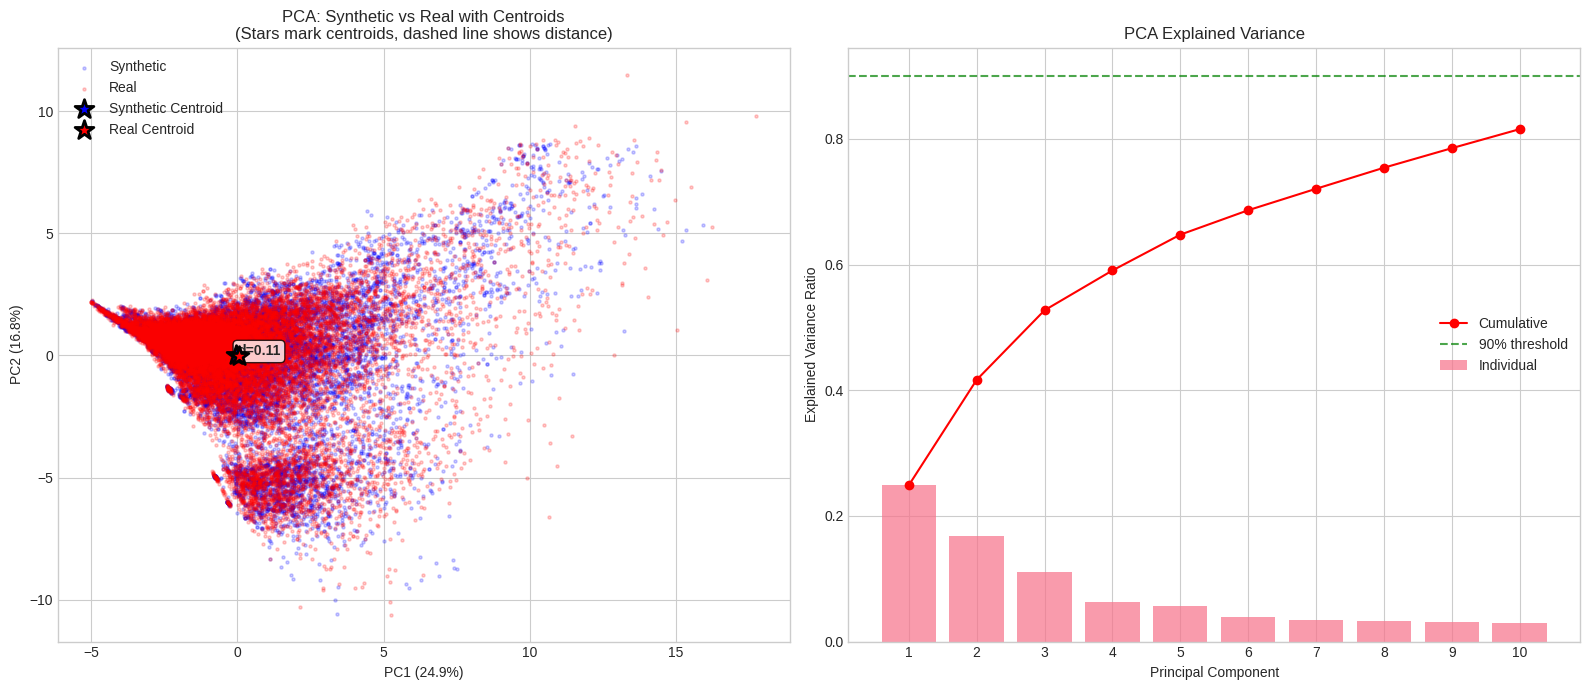

Saved: /home/smotaali/BGP_Traffic_Generation/results/SMOTE_enhanced/kmeans_v3_rrc04//enhanced_v3_pca_centroid_analysis.png


In [231]:
# Visualize PCA with centroids marked
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left: PCA scatter with centroids
ax1 = axes[0]
for label, color, marker in [('Synthetic', 'blue', 'o'), ('Real', 'red', 'o')]:
    mask = np.array(labels) == label
    ax1.scatter(X_pca_full[mask, 0], X_pca_full[mask, 1], c=color, alpha=0.2, s=5, label=label, marker=marker)

# Plot centroids
ax1.scatter(centroid_syn[0], centroid_syn[1], c='blue', s=200, marker='*', 
            edgecolors='black', linewidths=2, label='Synthetic Centroid', zorder=5)
ax1.scatter(centroid_real[0], centroid_real[1], c='red', s=200, marker='*', 
            edgecolors='black', linewidths=2, label='Real Centroid', zorder=5)

# Draw line between centroids
ax1.plot([centroid_syn[0], centroid_real[0]], [centroid_syn[1], centroid_real[1]], 
         'k--', linewidth=2, alpha=0.7)
ax1.annotate(f'd={centroid_distance_2d:.2f}', 
             xy=((centroid_syn[0]+centroid_real[0])/2, (centroid_syn[1]+centroid_real[1])/2),
             fontsize=10, fontweight='bold', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax1.set_title('PCA: Synthetic vs Real with Centroids\n(Stars mark centroids, dashed line shows distance)')
ax1.legend()

# Right: Explained variance
ax2 = axes[1]
components = range(1, len(pca.explained_variance_ratio_) + 1)
ax2.bar(components, pca.explained_variance_ratio_, alpha=0.7, label='Individual')
ax2.plot(components, cumvar, 'ro-', label='Cumulative')
ax2.axhline(y=0.9, color='g', linestyle='--', alpha=0.7, label='90% threshold')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Explained Variance Ratio')
ax2.set_title('PCA Explained Variance')
ax2.legend()
ax2.set_xticks(components)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/enhanced_v3_pca_centroid_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/enhanced_v3_pca_centroid_analysis.png")

In [232]:
# =============================================================================
# ENHANCED: t-SNE Overlay with Density Comparison
# =============================================================================
# Stratified t-SNE with visual overlay to assess distribution matching

n_tsne_samples = min(5000, len(X_scaled))
n_each = n_tsne_samples // 2

np.random.seed(RANDOM_SEED)

# Stratified sampling: equal from synthetic and real
syn_indices = np.random.choice(len(X_synthetic), n_each, replace=False)
real_indices = np.random.choice(len(X_real), n_each, replace=False) + len(X_synthetic)
tsne_idx = np.concatenate([syn_indices, real_indices])
np.random.shuffle(tsne_idx)

# Store indices for reproducibility
tsne_indices_info = {
    'synthetic_indices': syn_indices.tolist(),
    'real_indices': (real_indices - len(X_synthetic)).tolist(),
    'combined_indices': tsne_idx.tolist(),
    'random_seed': RANDOM_SEED,
    'n_synthetic': n_each,
    'n_real': n_each
}
with open(f'{OUTPUT_DIR}/enhanced_v3_tsne_indices.json', 'w') as f:
    json.dump(tsne_indices_info, f, indent=2)

# Perform t-SNE
print("Running t-SNE (this may take a moment)...")
tsne = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled[tsne_idx])
labels_tsne = [labels[i] for i in tsne_idx]

print(f"t-SNE completed on {n_tsne_samples} samples")
print(f"  - Synthetic samples: {n_each}")
print(f"  - Real samples: {n_each}")

Running t-SNE (this may take a moment)...


t-SNE completed on 5000 samples
  - Synthetic samples: 2500
  - Real samples: 2500


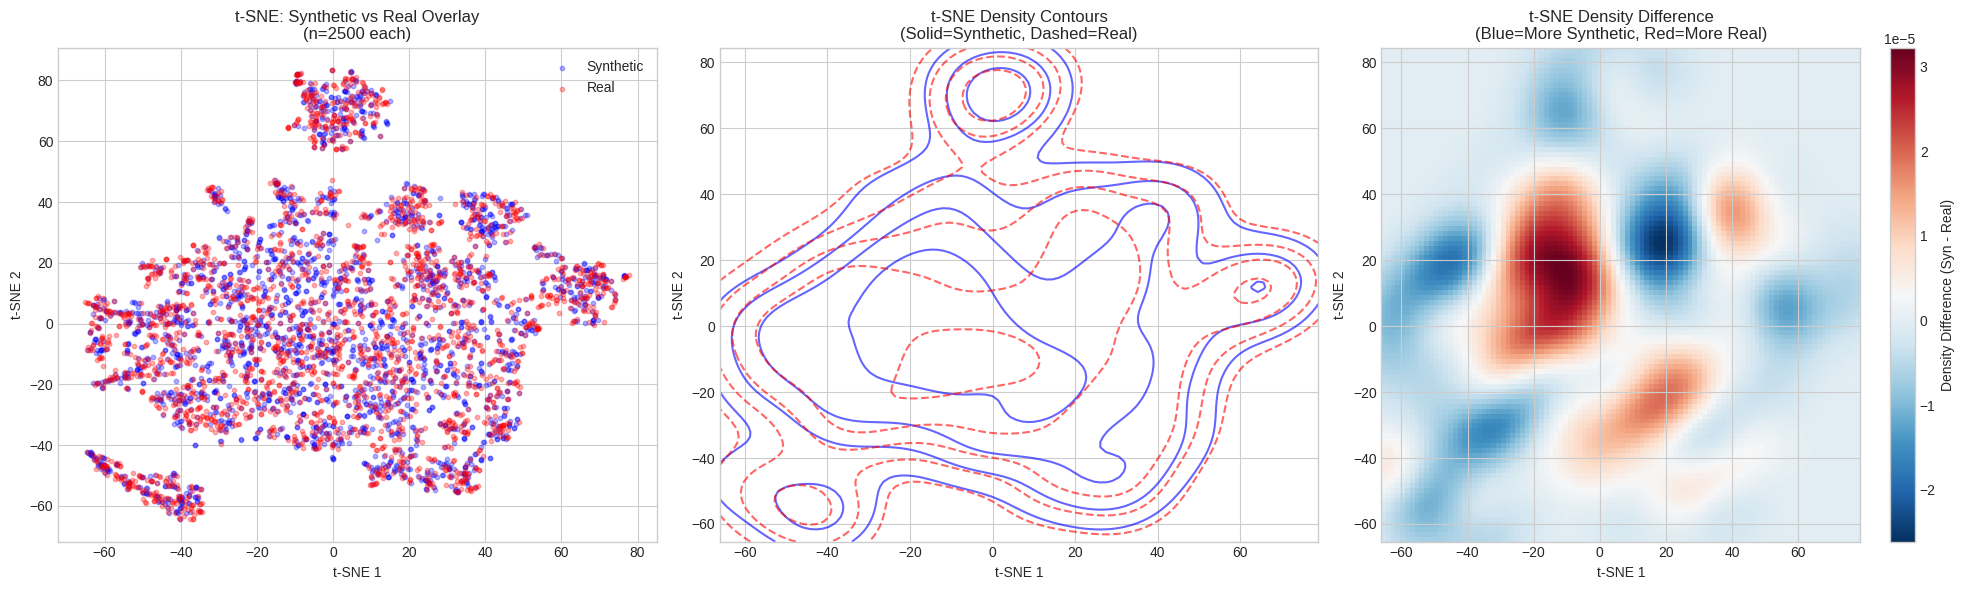

Saved: /home/smotaali/BGP_Traffic_Generation/results/SMOTE_enhanced/kmeans_v3_rrc04//enhanced_v3_tsne_overlay.png


In [233]:
# Visualize t-SNE with density overlay
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Left: Standard t-SNE scatter
ax1 = axes[0]
for label, color in [('Synthetic', 'blue'), ('Real', 'red')]:
    mask = np.array(labels_tsne) == label
    ax1.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=color, alpha=0.3, s=10, label=label)
ax1.set_xlabel('t-SNE 1')
ax1.set_ylabel('t-SNE 2')
ax1.set_title(f't-SNE: Synthetic vs Real Overlay\n(n={n_each} each)')
ax1.legend()

# Middle: 2D KDE density plot for synthetic
ax2 = axes[1]
mask_syn = np.array(labels_tsne) == 'Synthetic'
mask_real = np.array(labels_tsne) == 'Real'

try:
    # KDE for synthetic (blue contours)
    from scipy.stats import gaussian_kde
    xy_syn = np.vstack([X_tsne[mask_syn, 0], X_tsne[mask_syn, 1]])
    kde_syn = gaussian_kde(xy_syn)
    
    xy_real = np.vstack([X_tsne[mask_real, 0], X_tsne[mask_real, 1]])
    kde_real = gaussian_kde(xy_real)
    
    # Create grid
    x_min, x_max = X_tsne[:, 0].min() - 1, X_tsne[:, 0].max() + 1
    y_min, y_max = X_tsne[:, 1].min() - 1, X_tsne[:, 1].max() + 1
    xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    
    # Evaluate KDEs
    z_syn = np.reshape(kde_syn(positions).T, xx.shape)
    z_real = np.reshape(kde_real(positions).T, xx.shape)
    
    # Plot contours
    ax2.contour(xx, yy, z_syn, levels=5, colors='blue', alpha=0.6, linestyles='-')
    ax2.contour(xx, yy, z_real, levels=5, colors='red', alpha=0.6, linestyles='--')
    ax2.set_xlabel('t-SNE 1')
    ax2.set_ylabel('t-SNE 2')
    ax2.set_title('t-SNE Density Contours\n(Solid=Synthetic, Dashed=Real)')
    
except Exception as e:
    ax2.text(0.5, 0.5, f'KDE failed: {str(e)}', transform=ax2.transAxes, ha='center')
    ax2.set_title('t-SNE Density Contours (Failed)')

# Right: Density difference heatmap
ax3 = axes[2]
try:
    # Calculate density difference
    z_diff = z_syn - z_real
    
    im = ax3.imshow(z_diff.T, extent=[x_min, x_max, y_min, y_max], 
                    origin='lower', cmap='RdBu_r', aspect='auto')
    plt.colorbar(im, ax=ax3, label='Density Difference (Syn - Real)')
    ax3.set_xlabel('t-SNE 1')
    ax3.set_ylabel('t-SNE 2')
    ax3.set_title('t-SNE Density Difference\n(Blue=More Synthetic, Red=More Real)')
except Exception as e:
    ax3.text(0.5, 0.5, f'Density diff failed: {str(e)}', transform=ax3.transAxes, ha='center')
    ax3.set_title('t-SNE Density Difference (Failed)')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/enhanced_v3_tsne_overlay.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/enhanced_v3_tsne_overlay.png")

In [234]:
# Calculate t-SNE centroids and distance
tsne_centroid_syn = X_tsne[mask_syn].mean(axis=0)
tsne_centroid_real = X_tsne[mask_real].mean(axis=0)
tsne_centroid_distance = np.linalg.norm(tsne_centroid_syn - tsne_centroid_real)

print("\nt-SNE Centroid Analysis:")
print(f"   Synthetic centroid: ({tsne_centroid_syn[0]:.2f}, {tsne_centroid_syn[1]:.2f})")
print(f"   Real centroid: ({tsne_centroid_real[0]:.2f}, {tsne_centroid_real[1]:.2f})")
print(f"   Distance: {tsne_centroid_distance:.4f}")

# Note: t-SNE distances are not directly interpretable, but relative comparison is useful
print("\n   Note: t-SNE distances are not directly interpretable as absolute measures,")
print("   but provide relative comparison of cluster separation.")


t-SNE Centroid Analysis:
   Synthetic centroid: (0.34, 0.33)
   Real centroid: (-0.09, 0.58)
   Distance: 0.4958

   Note: t-SNE distances are not directly interpretable as absolute measures,
   but provide relative comparison of cluster separation.


## 10. Enhanced Summary Report with Feature-Weighted Scoring

In [235]:
# =============================================================================
# ENHANCED: Calculate Overall Similarity Score with Feature Importance Weights
# =============================================================================
# This version weights operationally critical BGP features more heavily

print("=" * 80)
print("PHASE 1: NORMAL TRAFFIC VALIDATION - ENHANCED SUMMARY REPORT v3")
print("=" * 80)

# Get weights for each feature
feature_weights = np.array([
    FEATURE_IMPORTANCE_WEIGHTS.get(col, FEATURE_IMPORTANCE_WEIGHTS['_default']) 
    for col in feature_cols
])
total_weight = feature_weights.sum()

# Component 1: WEIGHTED Distribution Similarity
# Weight the KS threshold pass/fail by feature importance
ks_pass_weighted = sum(
    FEATURE_IMPORTANCE_WEIGHTS.get(row['feature'], 1.0) 
    for _, row in ks_df.iterrows() 
    if row['similarity_level'] in ['Excellent', 'Good']
)
distribution_score_weighted = (ks_pass_weighted / total_weight) * 100

# Also calculate unweighted for comparison
good_or_better = (ks_df['similarity_level'].isin(['Excellent', 'Good'])).sum()
distribution_score_unweighted = (good_or_better / len(feature_cols)) * 100

# Component 2: Correlation Structure Similarity (unchanged - global metric)
correlation_score = ((structure_corr + 1) / 2) * 100

# Component 3: WEIGHTED Effect Size Score
effect_counts = effect_df['interpretation'].value_counts()
negligible_count = effect_counts.get('Negligible', 0)
small_count = effect_counts.get('Small', 0)
medium_count = effect_counts.get('Medium', 0)
large_count = effect_counts.get('Large', 0)

# Calculate weighted effect score
effect_score_weighted = 0
for _, row in effect_df.iterrows():
    weight = row['importance_weight']
    if row['interpretation'] == 'Negligible':
        effect_score_weighted += weight * 1.0
    elif row['interpretation'] == 'Small':
        effect_score_weighted += weight * 0.75
    elif row['interpretation'] == 'Medium':
        effect_score_weighted += weight * 0.25
    else:  # Large
        effect_score_weighted += weight * 0.0
effect_score_weighted = (effect_score_weighted / total_weight) * 100

# Unweighted for comparison
effect_score_unweighted = ((negligible_count * 1.0 + small_count * 0.75 + 
                            medium_count * 0.25 + large_count * 0.0) / len(feature_cols)) * 100

# Component 4: WEIGHTED Wasserstein Distance Score
wd_weighted = sum(
    row['wasserstein_distance'] * FEATURE_IMPORTANCE_WEIGHTS.get(row['feature'], 1.0)
    for _, row in ks_df.iterrows()
) / total_weight
wasserstein_score_weighted = max(0, (1 - wd_weighted * 2)) * 100

# Unweighted for comparison
mean_wd = ks_df['wasserstein_distance'].mean()
wasserstein_score_unweighted = max(0, (1 - mean_wd * 2)) * 100

# Component 5: NEW - Multivariate (PCA Centroid) Score
# Scale centroid distance to a 0-100 score
pca_score = max(0, (1 - centroid_distance / 3)) * 100  # distance of 3 = 0%

# ENHANCED Overall Score with feature weights
weights_components = {
    'distribution': 0.20,
    'correlation': 0.20,
    'effect_size': 0.25,
    'wasserstein': 0.15,
    'multivariate': 0.20
}

overall_score_weighted = (
    distribution_score_weighted * weights_components['distribution'] +
    correlation_score * weights_components['correlation'] +
    effect_score_weighted * weights_components['effect_size'] +
    wasserstein_score_weighted * weights_components['wasserstein'] +
    pca_score * weights_components['multivariate']
)

# Also calculate unweighted for comparison
overall_score_unweighted = (
    distribution_score_unweighted * weights_components['distribution'] +
    correlation_score * weights_components['correlation'] +
    effect_score_unweighted * weights_components['effect_size'] +
    wasserstein_score_unweighted * weights_components['wasserstein'] +
    pca_score * weights_components['multivariate']
)

# Count problematic features
n_constant_syn_only = len(problematic_features['constant_synthetic_only'])
n_constant_real_only = len(problematic_features['constant_real_only'])
n_constant_both = len(problematic_features['constant_both'])
mean_ks = ks_df['ks_statistic'].mean()

PHASE 1: NORMAL TRAFFIC VALIDATION - ENHANCED SUMMARY REPORT v3


In [236]:
# Print detailed summary report
print(f"\nDATA OVERVIEW")
print(f"   Synthetic normal samples: {len(synthetic_sampled):,}")
print(f"   Real normal samples: {len(real_sampled):,}")
print(f"   Total features: {len(feature_cols) + n_constant_both + n_constant_syn_only + n_constant_real_only}")
print(f"   Valid features for comparison: {len(feature_cols)}")

print(f"\nFEATURE QUALITY ISSUES")
print(f"   Constant in both (excluded): {n_constant_both}")
print(f"   [WARNING] Constant in synthetic only (GAN issue): {n_constant_syn_only}")
print(f"   [WARNING] Constant in real only (data issue): {n_constant_real_only}")

print(f"\nDISTRIBUTION SIMILARITY (Feature-Weighted)")
print(f"   KS-Test (threshold-based):")
print(f"     - Excellent (KS < {KS_EXCELLENT_THRESHOLD}): {(ks_df['similarity_level'] == 'Excellent').sum()}/{len(feature_cols)}")
print(f"     - Good or Better: {good_or_better}/{len(feature_cols)}")
print(f"     - Mean KS statistic: {mean_ks:.4f}")
print(f"   Wasserstein Distance:")
print(f"     - Mean: {mean_wd:.4f}")
print(f"     - Weighted Mean: {wd_weighted:.4f}")

print(f"\nCORRELATION STRUCTURE")
print(f"   Pearson correlation of matrices: {structure_corr:.4f}")
print(f"   Spearman correlation of matrices: {structure_spearman:.4f}")
print(f"   Mean absolute correlation difference: {corr_diff.values.mean():.4f}")

print(f"\nEFFECT SIZES (Cohen's d)")
for interp in ['Negligible', 'Small', 'Medium', 'Large']:
    count = effect_counts.get(interp, 0)
    print(f"   {interp}: {count} features")

print(f"\nMULTIVARIATE ANALYSIS")
print(f"   PCA Centroid Distance: {centroid_distance:.4f}")
if not np.isnan(mahal_distance):
    print(f"   Mahalanobis Distance: {mahal_distance:.4f}")
print(f"   t-SNE Centroid Distance: {tsne_centroid_distance:.4f}")

print(f"\n" + "=" * 80)
print("OVERALL ASSESSMENT (with Feature Importance Weighting)")
print("=" * 80)

print(f"\nComponent Scores (weighted / unweighted):")
print(f"  - Distribution (KS): {distribution_score_weighted:.1f} / {distribution_score_unweighted:.1f} (weight: {weights_components['distribution']*100:.0f}%)")
print(f"  - Correlation Structure: {correlation_score:.1f} / {correlation_score:.1f} (weight: {weights_components['correlation']*100:.0f}%)")
print(f"  - Effect Size: {effect_score_weighted:.1f} / {effect_score_unweighted:.1f} (weight: {weights_components['effect_size']*100:.0f}%)")
print(f"  - Wasserstein: {wasserstein_score_weighted:.1f} / {wasserstein_score_unweighted:.1f} (weight: {weights_components['wasserstein']*100:.0f}%)")
print(f"  - Multivariate (PCA): {pca_score:.1f} / {pca_score:.1f} (weight: {weights_components['multivariate']*100:.0f}%)")
print(f"  -----------------------------------------------")
print(f"  OVERALL (WEIGHTED): {overall_score_weighted:.1f}/100")
print(f"  OVERALL (UNWEIGHTED): {overall_score_unweighted:.1f}/100")
print(f"  Impact of Feature Weighting: {overall_score_weighted - overall_score_unweighted:+.1f} points")

if overall_score_weighted >= 80:
    verdict = "[EXCELLENT] Synthetic data closely matches real traffic"
elif overall_score_weighted >= 70:
    verdict = "[GOOD] Synthetic data reasonably represents real traffic"
elif overall_score_weighted >= 50:
    verdict = "[MODERATE] Some features need improvement"
else:
    verdict = "[POOR] Significant differences detected"
print(f"\n   Verdict: {verdict}")


DATA OVERVIEW
   Synthetic normal samples: 19,994
   Real normal samples: 19,994
   Total features: 27
   Valid features for comparison: 27

FEATURE QUALITY ISSUES
   Constant in both (excluded): 0
   [WARNING] Constant in synthetic only (GAN issue): 0
   [WARNING] Constant in real only (data issue): 0

DISTRIBUTION SIMILARITY (Feature-Weighted)
   KS-Test (threshold-based):
     - Excellent (KS < 0.05): 26/27
     - Good or Better: 27/27
     - Mean KS statistic: 0.0257
   Wasserstein Distance:
     - Mean: 0.0488
     - Weighted Mean: 0.0491

CORRELATION STRUCTURE
   Pearson correlation of matrices: 0.9960
   Spearman correlation of matrices: 0.9869
   Mean absolute correlation difference: 0.0214

EFFECT SIZES (Cohen's d)
   Negligible: 27 features
   Small: 0 features
   Medium: 0 features
   Large: 0 features

MULTIVARIATE ANALYSIS
   PCA Centroid Distance: 0.1507
   Mahalanobis Distance: 0.0953
   t-SNE Centroid Distance: 0.4958

OVERALL ASSESSMENT (with Feature Importance Weight

In [237]:
# Print features needing attention
print(f"\nFEATURES NEEDING ATTENTION (Ranked by Weighted Impact):")

# Features with large effect size
large_effect = effect_df[effect_df['interpretation'] == 'Large']['feature'].tolist()
# Features with poor KS similarity  
poor_ks = ks_df[ks_df['similarity_level'] == 'Poor']['feature'].tolist()
# Features constant in synthetic only (GAN not learning variance)
const_syn_features = [item['feature'] for item in problematic_features['constant_synthetic_only']]

# Combine and rank by importance weight
attention_features = list(set(large_effect + poor_ks + const_syn_features))
if attention_features:
    attention_with_weights = []
    for f in attention_features:
        weight = FEATURE_IMPORTANCE_WEIGHTS.get(f, FEATURE_IMPORTANCE_WEIGHTS['_default'])
        reasons = []
        if f in large_effect:
            d_val = effect_df[effect_df['feature'] == f]['cohens_d'].values[0]
            reasons.append(f"Large effect (d={d_val:.3f})")
        if f in poor_ks:
            ks_val = ks_df[ks_df['feature'] == f]['ks_statistic'].values[0]
            reasons.append(f"Poor KS ({ks_val:.3f})")
        if f in const_syn_features:
            reasons.append("Constant in synthetic (GAN issue)")
        attention_with_weights.append((f, weight, reasons))
    
    # Sort by importance weight (highest first)
    attention_with_weights.sort(key=lambda x: x[1], reverse=True)
    
    for f, weight, reasons in attention_with_weights:
        print(f"   - {f} (W={weight:.1f}): {', '.join(reasons)}")
else:
    print("   None - all features have acceptable similarity")

print("\n" + "=" * 80)


FEATURES NEEDING ATTENTION (Ranked by Weighted Impact):
   None - all features have acceptable similarity



In [238]:
# Save detailed results to CSV
results_df = ks_df[['feature', 'ks_statistic', 'wasserstein_distance', 'similarity_level', 'importance_weight']].merge(
    mw_df[['feature', 'mw_statistic', 'adjusted_p_value']], on='feature'
)
results_df = results_df.merge(
    effect_df[['feature', 'cohens_d', 'interpretation', 'capped']], on='feature'
)
results_df = results_df.merge(
    mean_diff.reset_index().rename(columns={'index': 'feature'})[['feature', 'synthetic_mean', 'real_mean', 'abs_diff', 'pct_diff']], 
    on='feature'
)

results_df.to_csv(f'{OUTPUT_DIR}/enhanced_v3_detailed_results.csv', index=False)
print(f"Detailed results saved to: {OUTPUT_DIR}/enhanced_v3_detailed_results.csv")

# Display final table
print("\nFinal Results Table:")
results_df

Detailed results saved to: /home/smotaali/BGP_Traffic_Generation/results/SMOTE_enhanced/kmeans_v3_rrc04//enhanced_v3_detailed_results.csv

Final Results Table:


,feature,ks_statistic,wasserstein_distance,similarity_level,importance_weight,mw_statistic,adjusted_p_value,cohens_d,interpretation,capped,synthetic_mean,real_mean,abs_diff,pct_diff
0,edit_distance_avg,0.058818,0.034013,Good,1.0,198036212.0,0.198118,-0.025994,Negligible,False,1.776907,1.801563,0.024656,1.368584
1,edit_distance_dict_2,0.045264,0.055041,Excellent,1.0,203166470.5,0.017787,-0.044704,Negligible,False,3.654896,3.935181,0.280284,7.122522
2,flaps,0.043413,0.069169,Excellent,1.5,204986710.0,0.000026,-0.030362,Negligible,False,1.641943,1.738822,0.096879,5.571535
3,edit_distance_dict_3,0.043163,0.081875,Excellent,1.0,205202765.5,0.000015,-0.025281,Negligible,False,1.565920,1.636741,0.070821,4.326967
4,nadas,0.040312,0.058044,Excellent,1.3,200546613.5,0.605580,-0.067695,Negligible,False,5.513204,6.266030,0.752826,12.014399
5,edit_distance_dict_4,0.036161,0.087274,Excellent,1.0,204629756.0,0.000016,-0.030658,Negligible,False,0.758428,0.815195,0.056767,6.963617
6,rare_ases_avg,0.035361,0.019318,Excellent,1.0,205857782.0,0.000006,0.019356,Negligible,False,0.147093,0.144911,0.002182,1.505982
7,unique_as_path_max,0.034410,0.089162,Excellent,1.0,204479933.5,0.000214,0.016677,Negligible,False,3.168300,3.146244,0.022057,0.701046
8,number_rare_ases,0.031609,0.024340,Excellent,1.0,200257860.0,0.743332,-0.025860,Negligible,False,36.700110,37.493048,0.792938,2.114893
9,edit_distance_dict_1,0.030359,0.035684,Excellent,1.0,202453932.0,0.069538,-0.012389,Negligible,False,3.193708,3.256277,0.062569,1.921482


In [239]:
# Save summary statistics
summary_stats = pd.DataFrame({
    'Metric': [
        'Synthetic Samples',
        'Real Samples', 
        'Valid Features Compared',
        'Constant in Both (Excluded)',
        'Constant in Synthetic Only (GAN Issue)',
        'Constant in Real Only',
        'KS Excellent Features',
        'KS Good or Better Features',
        'Mean KS Statistic',
        'Mean Wasserstein Distance',
        'Weighted Wasserstein Distance',
        'Correlation Similarity (Pearson)',
        'Correlation Similarity (Spearman)',
        'PCA Centroid Distance',
        'Negligible Effect Features',
        'Small Effect Features',
        'Medium Effect Features',
        'Large Effect Features',
        'Distribution Score (Weighted)',
        'Distribution Score (Unweighted)',
        'Correlation Score',
        'Effect Size Score (Weighted)',
        'Effect Size Score (Unweighted)',
        'Wasserstein Score (Weighted)',
        'Multivariate (PCA) Score',
        'Overall Similarity Score (WEIGHTED)',
        'Overall Similarity Score (UNWEIGHTED)',
        'Weighting Impact'
    ],
    'Value': [
        len(synthetic_sampled),
        len(real_sampled),
        len(feature_cols),
        n_constant_both,
        n_constant_syn_only,
        n_constant_real_only,
        (ks_df['similarity_level'] == 'Excellent').sum(),
        good_or_better,
        f"{mean_ks:.4f}",
        f"{mean_wd:.4f}",
        f"{wd_weighted:.4f}",
        f"{structure_corr:.4f}",
        f"{structure_spearman:.4f}",
        f"{centroid_distance:.4f}",
        effect_counts.get('Negligible', 0),
        effect_counts.get('Small', 0),
        effect_counts.get('Medium', 0),
        effect_counts.get('Large', 0),
        f"{distribution_score_weighted:.1f}/100",
        f"{distribution_score_unweighted:.1f}/100",
        f"{correlation_score:.1f}/100",
        f"{effect_score_weighted:.1f}/100",
        f"{effect_score_unweighted:.1f}/100",
        f"{wasserstein_score_weighted:.1f}/100",
        f"{pca_score:.1f}/100",
        f"{overall_score_weighted:.1f}/100",
        f"{overall_score_unweighted:.1f}/100",
        f"{overall_score_weighted - overall_score_unweighted:+.1f} points"
    ]
})

summary_stats.to_csv(f'{OUTPUT_DIR}/enhanced_v3_summary.csv', index=False)
print(f"Summary saved to: {OUTPUT_DIR}/enhanced_v3_summary.csv")
summary_stats

Summary saved to: /home/smotaali/BGP_Traffic_Generation/results/SMOTE_enhanced/kmeans_v3_rrc04//enhanced_v3_summary.csv


,Metric,Value
0,Synthetic Samples,19994
1,Real Samples,19994
2,Valid Features Compared,27
3,Constant in Both (Excluded),0
4,Constant in Synthetic Only (GAN Issue),0
5,Constant in Real Only,0
6,KS Excellent Features,26
7,KS Good or Better Features,27
8,Mean KS Statistic,0.0257
9,Mean Wasserstein Distance,0.0488


## 11. Quality Assessment Dashboard

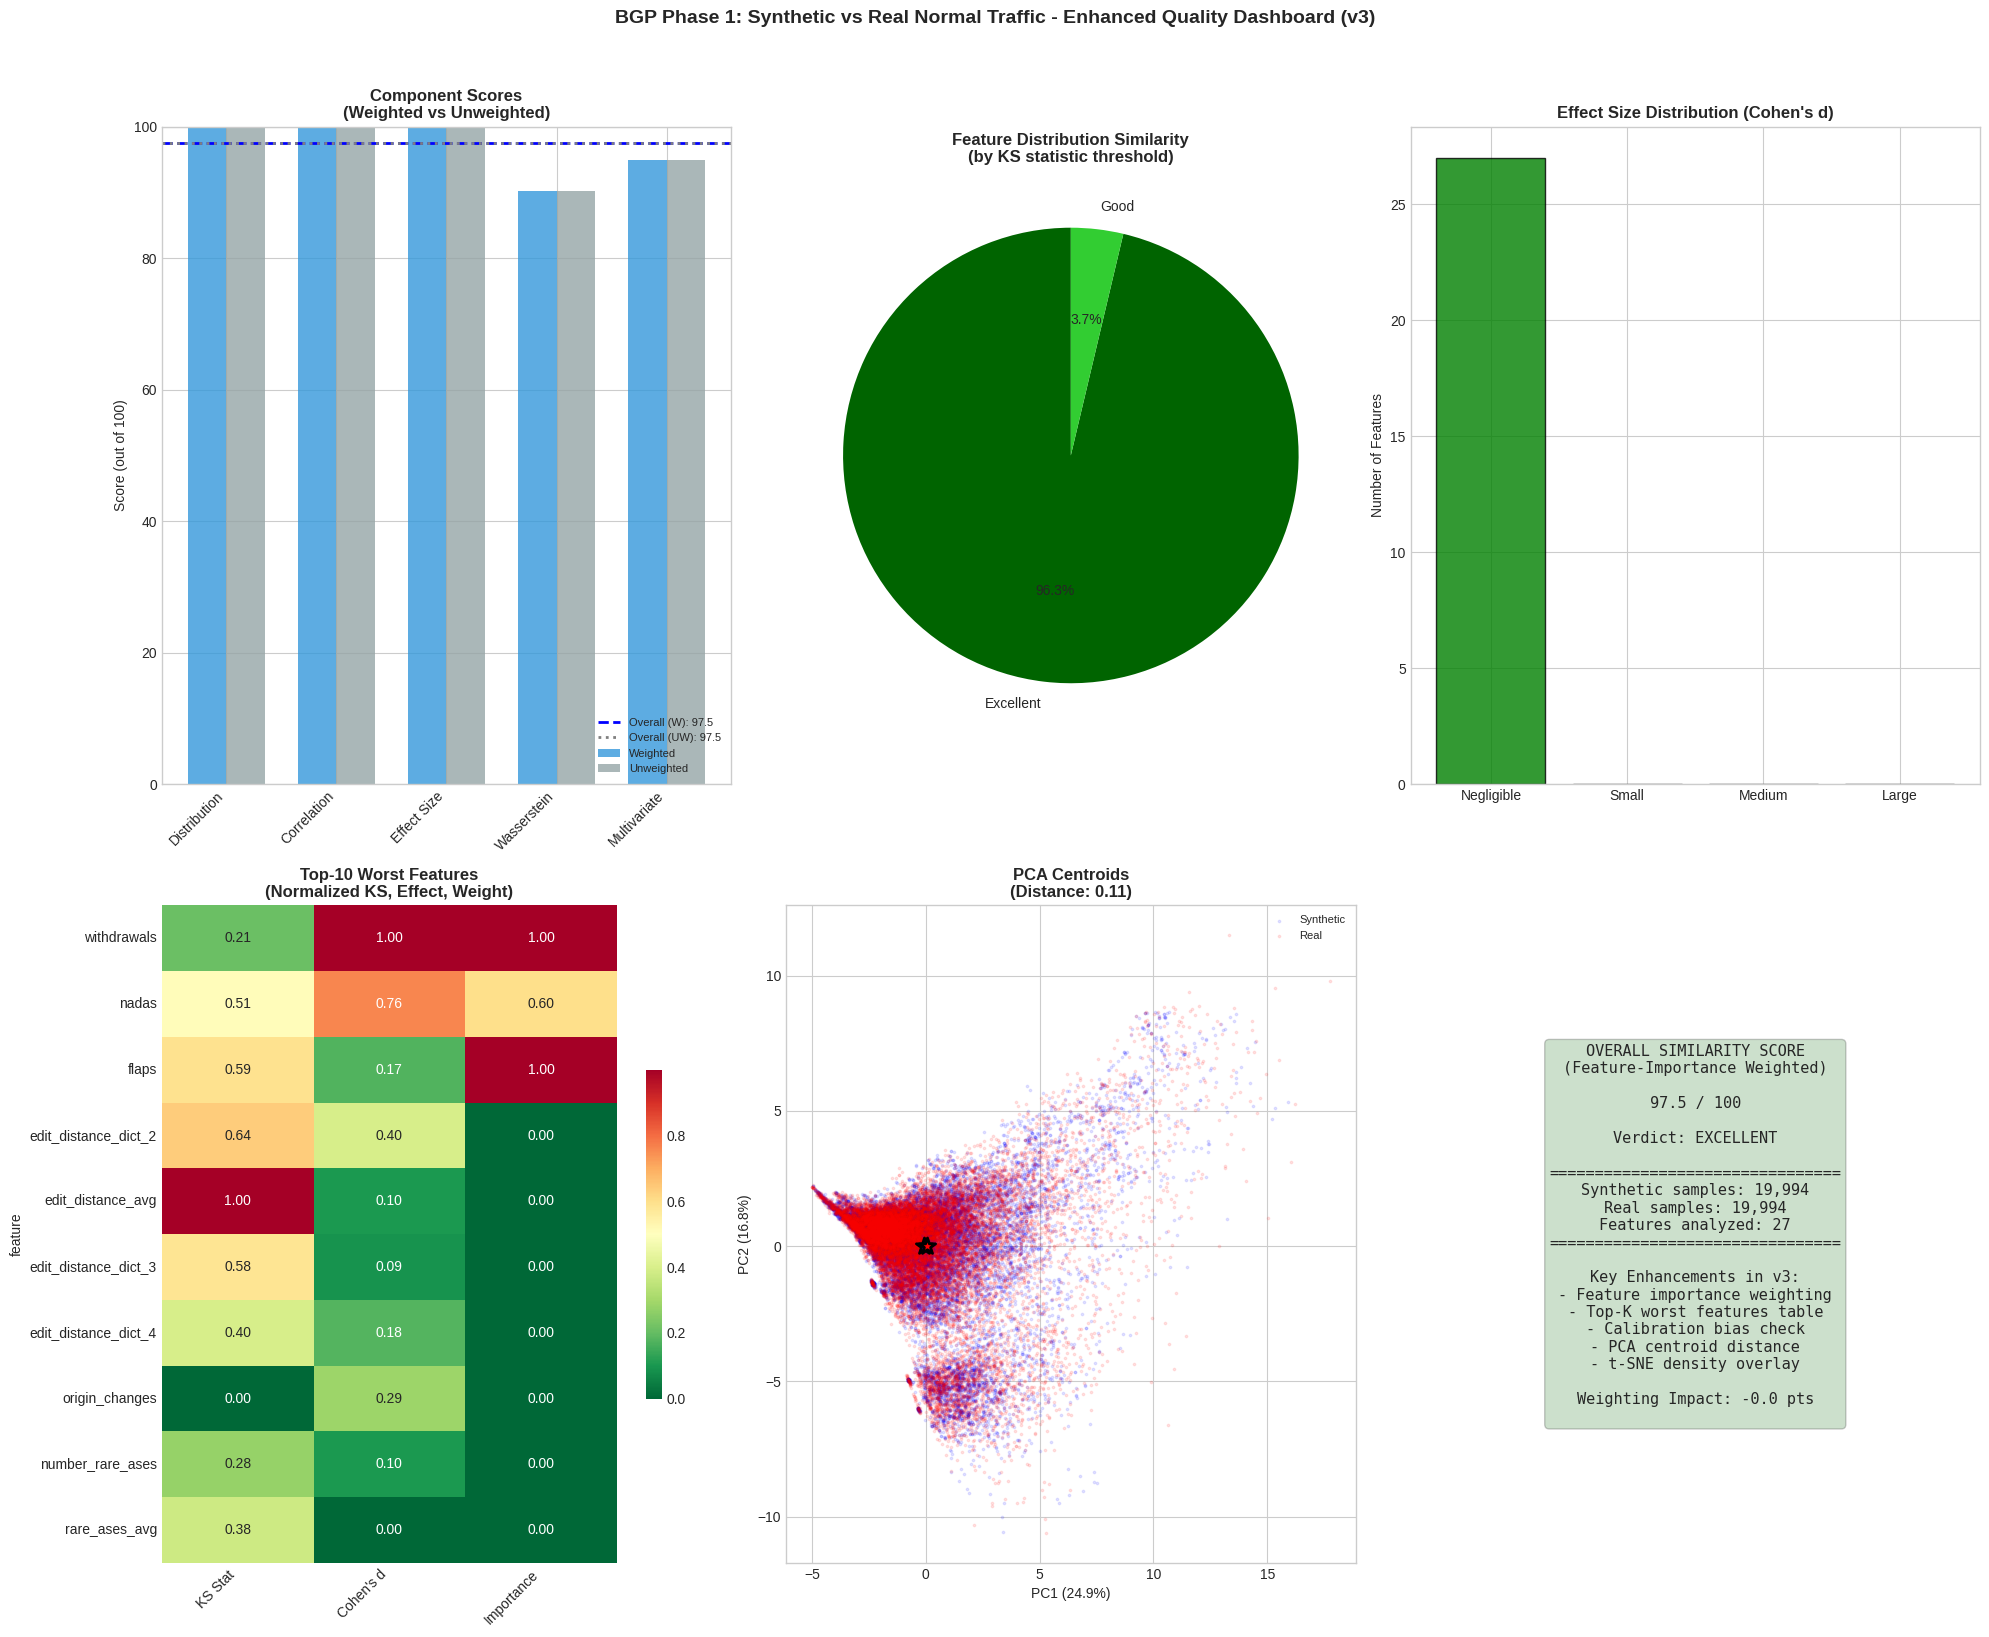

Saved: /home/smotaali/BGP_Traffic_Generation/results/SMOTE_enhanced/kmeans_v3_rrc04//enhanced_v3_quality_dashboard.png


In [240]:
# Create a comprehensive quality dashboard
fig = plt.figure(figsize=(20, 16))

# 1. Score breakdown (bar chart) - comparing weighted vs unweighted
ax1 = fig.add_subplot(2, 3, 1)
score_names = ['Distribution', 'Correlation', 'Effect Size', 'Wasserstein', 'Multivariate']
scores_weighted = [distribution_score_weighted, correlation_score, effect_score_weighted, 
                   wasserstein_score_weighted, pca_score]
scores_unweighted = [distribution_score_unweighted, correlation_score, effect_score_unweighted,
                     wasserstein_score_unweighted, pca_score]

x = np.arange(len(score_names))
width = 0.35
bars1 = ax1.bar(x - width/2, scores_weighted, width, label='Weighted', alpha=0.8, color='#3498db')
bars2 = ax1.bar(x + width/2, scores_unweighted, width, label='Unweighted', alpha=0.8, color='#95a5a6')

ax1.axhline(y=overall_score_weighted, color='blue', linestyle='--', linewidth=2, 
            label=f'Overall (W): {overall_score_weighted:.1f}')
ax1.axhline(y=overall_score_unweighted, color='gray', linestyle=':', linewidth=2,
            label=f'Overall (UW): {overall_score_unweighted:.1f}')
ax1.set_ylabel('Score (out of 100)')
ax1.set_title('Component Scores\n(Weighted vs Unweighted)', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(score_names, rotation=45, ha='right')
ax1.set_ylim(0, 100)
ax1.legend(loc='lower right', fontsize=8)

# 2. KS statistic distribution (pie chart)
ax2 = fig.add_subplot(2, 3, 2)
similarity_counts = ks_df['similarity_level'].value_counts()
colors_sim = {'Excellent': 'darkgreen', 'Good': 'limegreen', 'Moderate': 'orange', 'Poor': 'red'}
pie_colors = [colors_sim[level] for level in similarity_counts.index]
ax2.pie(similarity_counts.values, labels=similarity_counts.index, colors=pie_colors,
        autopct='%1.1f%%', startangle=90)
ax2.set_title('Feature Distribution Similarity\n(by KS statistic threshold)', fontweight='bold')

# 3. Effect size distribution
ax3 = fig.add_subplot(2, 3, 3)
effect_order = ['Negligible', 'Small', 'Medium', 'Large']
effect_colors = ['green', 'yellowgreen', 'orange', 'red']
effect_values = [effect_counts.get(e, 0) for e in effect_order]
ax3.bar(effect_order, effect_values, color=effect_colors, alpha=0.8, edgecolor='black')
ax3.set_ylabel('Number of Features')
ax3.set_title("Effect Size Distribution (Cohen's d)", fontweight='bold')

# 4. Feature importance heatmap (top features)
ax4 = fig.add_subplot(2, 3, 4)
top_features_for_heatmap = worst_features_ranked.head(10)[['feature', 'ks_statistic', 'abs_d', 'importance_weight']]
heatmap_data = top_features_for_heatmap.set_index('feature')[['ks_statistic', 'abs_d', 'importance_weight']]
# Normalize for visualization
heatmap_norm = heatmap_data.copy()
for col in heatmap_norm.columns:
    heatmap_norm[col] = (heatmap_data[col] - heatmap_data[col].min()) / (heatmap_data[col].max() - heatmap_data[col].min() + 1e-10)
sns.heatmap(heatmap_norm, ax=ax4, cmap='RdYlGn_r', annot=True, fmt='.2f', cbar_kws={'shrink': 0.5})
ax4.set_title('Top-10 Worst Features\n(Normalized KS, Effect, Weight)', fontweight='bold')
ax4.set_xticklabels(['KS Stat', "Cohen's d", 'Importance'], rotation=45, ha='right')

# 5. PCA centroid visualization (smaller version)
ax5 = fig.add_subplot(2, 3, 5)
for label, color in [('Synthetic', 'blue'), ('Real', 'red')]:
    mask = np.array(labels) == label
    ax5.scatter(X_pca_full[mask, 0], X_pca_full[mask, 1], c=color, alpha=0.1, s=3, label=label)
ax5.scatter(centroid_syn[0], centroid_syn[1], c='blue', s=150, marker='*', edgecolors='black', linewidths=2, zorder=5)
ax5.scatter(centroid_real[0], centroid_real[1], c='red', s=150, marker='*', edgecolors='black', linewidths=2, zorder=5)
ax5.plot([centroid_syn[0], centroid_real[0]], [centroid_syn[1], centroid_real[1]], 'k--', linewidth=2, alpha=0.7)
ax5.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax5.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax5.set_title(f'PCA Centroids\n(Distance: {centroid_distance_2d:.2f})', fontweight='bold')
ax5.legend(fontsize=8)

# 6. Overall verdict panel
ax6 = fig.add_subplot(2, 3, 6)
ax6.axis('off')

# Determine color based on score
if overall_score_weighted >= 80:
    verdict_color = 'darkgreen'
    verdict_text = 'EXCELLENT'
elif overall_score_weighted >= 70:
    verdict_color = 'green'
    verdict_text = 'GOOD'
elif overall_score_weighted >= 50:
    verdict_color = 'orange'
    verdict_text = 'MODERATE'
else:
    verdict_color = 'red'
    verdict_text = 'POOR'

textstr = f"""OVERALL SIMILARITY SCORE
(Feature-Importance Weighted)

{overall_score_weighted:.1f} / 100

Verdict: {verdict_text}

================================
Synthetic samples: {len(synthetic_sampled):,}
Real samples: {len(real_sampled):,}
Features analyzed: {len(feature_cols)}
================================

Key Enhancements in v3:
- Feature importance weighting
- Top-K worst features table
- Calibration bias check
- PCA centroid distance
- t-SNE density overlay

Weighting Impact: {overall_score_weighted - overall_score_unweighted:+.1f} pts
"""

ax6.text(0.5, 0.5, textstr, transform=ax6.transAxes, fontsize=11,
         verticalalignment='center', horizontalalignment='center',
         bbox=dict(boxstyle='round', facecolor=verdict_color, alpha=0.2),
         family='monospace')

plt.suptitle('BGP Phase 1: Synthetic vs Real Normal Traffic - Enhanced Quality Dashboard (v3)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/enhanced_v3_quality_dashboard.png', dpi=200, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/enhanced_v3_quality_dashboard.png")

In [241]:
# Save problematic features report with enhanced information
problematic_report = {
    'constant_both': problematic_features['constant_both'],
    'constant_synthetic_only': problematic_features['constant_synthetic_only'],
    'constant_real_only': problematic_features['constant_real_only'],
    'large_effect_size': large_effect,
    'poor_ks_similarity': poor_ks,
    'top_k_worst_features': top_k_worst['feature'].tolist(),
    'calibration_issues': {
        'features_with_mean_bias': calibration_df_raw[calibration_df_raw['potential_mean_bias']]['feature'].tolist(),
        'features_with_std_bias': calibration_df_raw[calibration_df_raw['potential_std_bias']]['feature'].tolist()
    },
    'multivariate_metrics': {
        'pca_centroid_distance': centroid_distance,
        'pca_centroid_distance_2d': centroid_distance_2d,
        'tsne_centroid_distance': tsne_centroid_distance
    },
    'feature_importance_weights': FEATURE_IMPORTANCE_WEIGHTS,
    'overall_scores': {
        'weighted': overall_score_weighted,
        'unweighted': overall_score_unweighted,
        'weighting_impact': overall_score_weighted - overall_score_unweighted
    }
}

with open(f'{OUTPUT_DIR}/enhanced_v3_problematic_features.json', 'w') as f:
    json.dump(problematic_report, f, indent=2, default=str)

print(f"Problematic features report saved to: {OUTPUT_DIR}/enhanced_v3_problematic_features.json")

Problematic features report saved to: /home/smotaali/BGP_Traffic_Generation/results/SMOTE_enhanced/kmeans_v3_rrc04//enhanced_v3_problematic_features.json
